<center><span style="font-size:28px; font-weight:bold;">Implementez un modèle de scoring</span><center>

<center><span style="font-size:28px; font-weight:bold;">2 - Modélisation</span><center>

# Sommaire

1. [Importation des librairies et des données](#1)
2. [Première modélisation : avec déséquilibre de classe](#2)
   - [Dummy Classifier](#2.1)
   - [Régression logistique](#2.2)
   - [Gradient Boosting](#2.3)
3. [Deuxième modélisation : après SMOTE](#3)
   - [Application du SMOTE](#3.1)
   - [Entraînement des modèles](#3.2)
   - [Évaluation du modèle](#3.3)
4. [Recherche des meilleurs hyperparamètres](#4)
   - [LGBM Classifier](#4.1)
   - [XGBoost Classifier](#4.2)
5. [Ajout d'un score métier](#5)
   - [Création du score métier](#5.1)
   - [Evaluation du score métier](#5.2)
   - [Essais empiriques pour ajuster cost_fn et cost_fp](#5.3)
6. [Modèle final optimisé](#6)
   - [Analyse des différents seuils et coûts](#6.1)
   - [Meilleures configurations en fonction du contexte](#6.2)
   - [Analyse de ces différentes configurations](#6.3)
7. [Features importance](#7)
8. [Conclusion](#8)

- Dans la première modélisation on va faire une sous partie par modèle pour bien expliquer tout. 
- Dans la deuxièeme on va fire une partie sur SMOTE pour expliquer le processus, puis une sous partie avec la modélisation, on peut faire un seul bloc de code pour la modélisation des 3 modèles. On peut également réserver une sous partie à l'évaluation. Attentin, faire un graphique pour analyser l'AUC après l'évaluation sur train (avec cross validation). (On peut utiliser le test set uniquement pour valider la modélisation finale ?)
- Idem que précédemment pour la partie après ajout du score métier.

# 1 - Importation des librairies et des données

## 1.1 - Importation des différentes librairies

In [78]:
import mlflow
import mlflow.sklearn

# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Autres bibliothèques utiles :
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_validate

from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import lightgbm as lgb
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import mlflow

from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from mlflow.models import infer_signature
from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import shap

In [2]:
# On va démarrer le chronomètre
start = time.time()

## 1.2 - Configuration de Mlflow

**MLflow** est une plateforme open source conçue pour gérer le cycle de vie des modèles de machine learning. Il permet de suivre les expérimentations, de versionner les modèles et de faciliter leur déploiement. 

Dans notre projet, **MLflow** est utilisé pour :

- **Suivre les runs** et les résultats des expérimentations.
- **Enregistrer les paramètres, métriques et artefacts** liés aux différents modèles.
- **Versionner les modèles optimisés** pour un futur déploiement.

**A - Les runs dans MLflow**

Un **run** dans MLflow correspond à une exécution de code qui est suivie, enregistrant des informations pertinentes telles que :

- Les **paramètres** d'entraînement utilisés (par exemple, les hyperparamètres comme le taux d'apprentissage ou le nombre d'estimations).
- Les **métriques** calculées (AUC, précision, temps d'exécution, etc.).
- Les **artefacts** produits (graphiques, modèles enregistrés, etc.).
- La **signature des données** (la structure des entrées et sorties du modèle).

**B - Enregistrement des modèles dans MLflow**

MLflow permet d’enregistrer les modèles pour une future utilisation via l'API **`mlflow.log_model()`**. Les modèles peuvent être :

- **Versionnés** et **stockés** avec les artefacts.
- **Récupérés** et **chargés** plus tard pour faire des prédictions ou les déployer dans des pipelines de production.

**C - Suivi des résultats avec MLflow**

Grâce à MLflow, nous pouvons consulter toutes nos expérimentations, comparer les runs, et identifier les meilleurs modèles en fonction des métriques enregistrées. MLflow permet également de visualiser des graphiques et de suivre les versions des modèles pour garder un historique détaillé des itérations de notre travail.

Par exemple, dans le **UI de MLflow**, nous pouvons facilement :

- **Comparer plusieurs runs** côte à côte pour voir quelle configuration a donné les meilleurs résultats.
- **Visualiser les métriques** pour chaque run et ajuster nos modèles en conséquence.

**D - Versioning des modèles**

MLflow offre également la possibilité de **versionner** les modèles grâce à un modèle registry. Chaque modèle enregistré dans le **Model Registry** peut être associé à une version, ce qui facilite le déploiement et la gestion continue des versions en production.

In [3]:
# On va configurer l'URI du serveur MLflow
mlflow.set_tracking_uri("http://localhost:5000")  # Remplacer par l'URI de notre serveur si nécessaire

Le code `mlflow.set_tracking_uri("http://localhost:5000")` sert à configurer l'URI du serveur de tracking MLflow.

   - L'URI spécifie où se trouve le serveur MLflow. Par défaut, MLflow utilise un serveur local en mémoire, ce qui signifie que les données ne seront pas conservées après l'arrêt de la session.
   - En définissant l'URI, nous pouvons nous connecter à un serveur MLflow qui stocke les résultats des expérimentations de manière persistante, ce qui permet d'accéder aux résultats ultérieurement.

## 1.3 - Importation des données

In [4]:
# Spécifions les différents chemins possibles
directories = [
    "C:\\Users\\mauge\\Documents\\github\\P7_implementer_modele_scoring",
    "/Users/Gary/Documents/GitHub/FormationData/DataScientist_P7/Projet+Mise+en+prod+-+home-credit-default-risk",
    "/Users/Gary/Documents/GitHub/P7_implementer_modele_scoring",
    "C:\\Users\\mauge\\OneDrive\\Bureau\\Projet+Mise+en+prod+-+home-credit-default-risk"
]

In [5]:
def load_csv(file_name, directory_options, **kwargs):
    for directory in directory_options:
        file_path = os.path.join(directory, file_name)
        if os.path.exists(file_path):
            print(f"Loading {file_name} from {file_path}")
            return pd.read_csv(file_path, **kwargs)
    print(f"{file_name} not found in any of the specified directories.")
    return None

# Chargement des fichiers
#df_application_train = load_csv('df_final.csv', directories)
df_data_6 = load_csv('df_data_6.csv', directories)
#X_train = load_csv('X_train.csv', directories)
#y_train = load_csv('y_train.csv', directories).values.ravel()
#X_test = load_csv('X_test.csv', directories)
#y_test = load_csv('y_test.csv', directories).values.ravel()

Loading df_data_6.csv from C:\Users\mauge\Documents\github\P7_implementer_modele_scoring\df_data_6.csv


In [77]:
df_data_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 346 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(346)
memory usage: 940.4 MB


In [6]:
df_application_train = load_csv('application_train.csv', directories)
df_application_test = load_csv('application_test.csv', directories)

Loading application_train.csv from C:\Users\mauge\OneDrive\Bureau\Projet+Mise+en+prod+-+home-credit-default-risk\application_train.csv
Loading application_test.csv from C:\Users\mauge\OneDrive\Bureau\Projet+Mise+en+prod+-+home-credit-default-risk\application_test.csv


## 1.4 - Définition des fonctions

In [7]:
def evaluate_models_with_cross_validation(models, X_train_split, y_train_split, log_to_mlflow=True):
    # Initialisation d'un DataFrame pour stocker les résultats
    results_df = pd.DataFrame(columns=['Model', 'AUC_mean', 'Accuracy_mean', 'Fit_time_mean', 'Score_time_mean'])

    for name, model in models.items():
        if log_to_mlflow:
            # Nom de la run MLflow avec le nom du modèle
            mlflow_run_name = f"{name}"

            # Démarre une nouvelle run MLflow
            with mlflow.start_run(run_name=mlflow_run_name):
                # Mesurer le temps de fitting
                start_fit_time = time.time()
                
                # Évaluation via cross-validation avec prédictions
                y_pred = cross_val_predict(model, X_train_split, y_train_split, cv=5, method='predict_proba', n_jobs=-1)
                
                end_fit_time = time.time()
                fit_time_mean = end_fit_time - start_fit_time

                # Calcul des scores
                auc_mean = roc_auc_score(y_train_split, y_pred[:, 1])
                accuracy_mean = accuracy_score(y_train_split, (y_pred[:, 1] >= 0.5).astype(int))

                # Mesurer le temps de scoring
                start_score_time = time.time()
                model.fit(X_train_split, y_train_split)  # Fit le modèle pour le scoring
                end_score_time = time.time()
                score_time_mean = end_score_time - start_score_time

                # Logging dans MLFlow
                mlflow.log_param("Model", name)
                mlflow.log_metric("AUC", auc_mean)
                mlflow.log_metric("Accuracy", accuracy_mean)
                mlflow.log_metric("Fit_time_mean", fit_time_mean)
                mlflow.log_metric("Score_time_mean", score_time_mean)

                # Générer la signature du modèle (entrées/sorties)
                signature = infer_signature(X_train_split, (y_pred[:, 1] >= 0.5).astype(int))

                # Enregistrement du modèle dans MLFlow et Model Registry avec versioning
                mlflow.sklearn.log_model(
                    model,
                    artifact_path="model",
                    signature=signature,
                    registered_model_name=f"{name}-classification-model"  # Enregistrement avec nom et versioning
                )

        else:
            # Évaluation via cross-validation sans logging
            y_pred = cross_val_predict(model, X_train_split, y_train_split, cv=5, method='predict_proba', n_jobs=-1)
            auc_mean = roc_auc_score(y_train_split, y_pred[:, 1])
            accuracy_mean = accuracy_score(y_train_split, (y_pred[:, 1] >= 0.5).astype(int))

        # Stockage dans DataFrame des résultats
        new_row = pd.DataFrame({
            'Model': [name],
            'AUC_mean': [auc_mean],
            'Accuracy_mean': [accuracy_mean],
            'Fit_time_mean': [fit_time_mean if log_to_mlflow else None],
            'Score_time_mean': [score_time_mean if log_to_mlflow else None],
        })
        
        results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    return results_df

La fonction `evaluate_models_with_cross_validation` évalue les modèles via validation croisée et logue les résultats dans MLflow si demandé.
    
Parameters:
    - models (dict): Dictionnaire contenant les noms et instances des modèles à évaluer.
    - X_train_split (pd.DataFrame): Données d'entraînement.
    - y_train_split (pd.Series): Cibles d'entraînement.
    - log_to_mlflow (bool): Si True, enregistre les résultats dans MLflow.

In [8]:
def evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name, retrain=False, log_to_mlflow=True):
    # Si l'enregistrement dans MLflow est activé
    if log_to_mlflow:
        # Nom de la run MLflow avec le suffixe "TEST"
        mlflow_run_name = f"{model_name} test_set"

        # Démarre une nouvelle run MLflow
        with mlflow.start_run(run_name=mlflow_run_name):
            if retrain:
                model.fit(X_train_split, y_train_split)

            # Fait les prédictions
            start_time = time.time()
            y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilités pour la classe positive
            y_pred = model.predict(X_val)
            prediction_time = time.time() - start_time

            # Calcule les métriques
            accuracy = accuracy_score(y_val, y_pred)
            roc_auc = roc_auc_score(y_val, y_pred_proba)
            precision = precision_score(y_val, y_pred)
            recall = recall_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred)
            cm = confusion_matrix(y_val, y_pred)

            # Logue les métriques dans MLflow
            mlflow.log_metric("Accuracy", accuracy)
            mlflow.log_metric("AUC", roc_auc)
            mlflow.log_metric("Precision", precision)
            mlflow.log_metric("Recall", recall)
            mlflow.log_metric("F1-score", f1)
            mlflow.log_metric("Score_time", prediction_time)

            # Enregistre le modèle dans MLflow
            mlflow.sklearn.log_model(model, "model")

            # Affiche les graphiques
            plot_confusion_matrix_and_roc(cm, y_val, y_pred_proba, roc_auc)

            # Enregistre les graphiques dans MLflow
            fig = plt.gcf()  # Récupérer la figure actuelle
            mlflow.log_figure(fig, "confusion_matrix_and_roc_curve.png")

    else:
        # Si l'enregistrement dans MLflow est désactivé
        if retrain:
            model.fit(X_train_split, y_train_split)

        # Fait les prédictions
        start_time = time.time()
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = model.predict(X_val)
        prediction_time = time.time() - start_time

        # Calcule les métriques
        accuracy = accuracy_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        cm = confusion_matrix(y_val, y_pred)

        # Affiche les résultats sans MLflow
        print(f'Accuracy: {accuracy:.4f}')
        print(f'AUC: {roc_auc:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1-score: {f1:.4f}')
        print("\nMatrice de confusion :")
        print(pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive']))

        # Affiche les graphiques
        plot_confusion_matrix_and_roc(cm, y_val, y_pred_proba, roc_auc)

**A tester ci dessous une version modifier du code qui permet d'enregistrer les graphiques sous mlflow.**

La fonction `evaluate_model` permet d'évaluer les performances d'un modèle de classification sur un ensemble de données de validation. Voici les principales métrics enregistrées par cette fonction :

L'**accuracy** : La précision du modèle est calculée à l'aide de l'accuracy score.

La **précision** mesure la proportion de prédictions positives qui sont effectivement correctes. C'est une métrique particulièrement utile dans les situations où le coût des faux positifs est élevé. Par exemple, dans un modèle de scoring de crédit, une faible précision signifierait que le modèle accorde trop souvent des crédits à des clients qui ne rembourseront pas.

Le **rappel** (ou sensibilité) mesure la proportion de véritables positifs correctement identifiés parmi l'ensemble des cas positifs réels. Le rappel est essentiel dans les scénarios où les faux négatifs (manquer des clients à risque) sont coûteux. Dans un modèle de scoring, un faible rappel signifie que le modèle ne détecte pas suffisamment de clients à risque.

Le **F1-score** est la moyenne harmonique de la précision et du rappel. Il est utile pour trouver un équilibre entre les deux, particulièrement quand il existe un déséquilibre entre les classes positives et négatives. Le F1-score est une bonne mesure globale dans des situations où il faut à la fois maximiser la précision et le rappel.

La **matrice de confusion** est un tableau qui permet de visualiser les performances d'un modèle de classification. Elle présente les comparaisons entre les vraies valeurs et les valeurs prédites par le modèle. Les quatre composantes de la matrice sont les suivantes :
- **Vrais Positifs (TP)** : Nombre de prédictions positives correctes (le modèle prédit que l'événement se produit et c'est effectivement le cas).
- **Faux Positifs (FP)** : Nombre de prédictions positives incorrectes (le modèle prédit que l'événement se produit, mais ce n'est pas le cas).
- **Vrais Négatifs (TN)** : Nombre de prédictions négatives correctes (le modèle prédit que l'événement ne se produit pas et c'est effectivement le cas).
- **Faux Négatifs (FN)** : Nombre de prédictions négatives incorrectes (le modèle prédit que l'événement ne se produit pas, mais il se produit en réalité).

Cette matrice est utile pour calculer des métriques telles que la **précision** (accuracy), la **précision** (precision), le **rappel** (recall), et le **F1-score**, qui sont des indicateurs clés de la performance globale du modèle.

La **courbe ROC (Receiver Operating Characteristic)** est un graphique qui évalue la capacité d'un modèle à distinguer entre les classes positives et négatives à différents seuils de décision. Chaque point de la courbe correspond à un certain seuil de classification. La courbe est tracée en fonction des axes suivants :
- **Axe des X (False Positive Rate, FPR)** : Taux de faux positifs, calculé comme le ratio entre les faux positifs et l'ensemble des réels négatifs (FP / (FP + TN)).
- **Axe des Y (True Positive Rate, TPR)** : Taux de vrais positifs (ou sensibilité), calculé comme le ratio entre les vrais positifs et l'ensemble des réels positifs (TP / (TP + FN)).

Un modèle parfait aurait une courbe ROC qui passe par le coin supérieur gauche du graphique, ce qui signifierait un taux de vrais positifs de 1 et un taux de faux positifs de 0.

L'**aire sous la courbe ROC (AUC)** est une mesure globale de la performance du modèle. Elle indique dans quelle mesure le modèle est capable de distinguer correctement les classes. L'aire sous la courbe varie entre 0 et 1 :
- **AUC = 1** : Le modèle est parfait.
- **AUC = 0.5** : Le modèle n'est pas meilleur qu'un classificateur aléatoire.
- **AUC < 0.5** : Le modèle se comporte pire qu'un classificateur aléatoire, indiquant une mauvaise classification des classes.

Une **AUC élevée** indique que le modèle fait bien la distinction entre les classes positives et négatives, même à différents seuils de classification.

In [9]:
def plot_confusion_matrix_and_roc(cm, y_val, y_pred_proba, roc_auc):
    # Fonction pour tracer la matrice de confusion et la courbe ROC
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

    # Affiche les deux graphiques côte à côte
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))

    # Matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], annot_kws={"size": 16})
    ax[0].set_xlabel('Predicted', fontsize=14)
    ax[0].set_ylabel('True', fontsize=14)
    ax[0].set_title('Matrice de confusion', fontsize=16)

    # Courbe ROC
    ax[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('False Positive Rate', fontsize=14)
    ax[1].set_ylabel('True Positive Rate', fontsize=14)
    ax[1].set_title('Courbe ROC', fontsize=16)
    ax[1].legend(loc='lower right', fontsize=12)

    plt.tight_layout()
    plt.show()

La fonction `plot_confusion_matrix_and_roc` affiche une matrice de confusion ainsi que la courbe AUC-ROC.

# 2 - Première modélisation : avec déséquilibre de classe

Dans notre cas, l'ensemble de test (`TEST`) ne contient pas la variable cible (`TARGET`). Par conséquent, nous ne pouvons pas évaluer directement les performances de nos modèles sur cet ensemble. Pour contourner ce problème et garantir une évaluation fiable, nous séparons l'ensemble d'entraînement (`TRAIN`) en deux sous-ensembles : un sous-ensemble d'entraînement et un sous-ensemble de validation.

Cette séparation nous permet de :
1. **Entraîner les Modèles** : Utiliser le sous-ensemble d'entraînement pour ajuster les paramètres du modèle.
2. **Évaluer les Modèles** : Utiliser le sous-ensemble de validation, qui contient les labels de la variable cible, pour évaluer les performances du modèle avant de le tester sur l'ensemble de test. 

Cela assure que le modèle est bien évalué et validé même si l'ensemble de test ne fournit pas de `TARGET`, nous permettant ainsi de juger de la performance et de la robustesse du modèle de manière fiable.

In [10]:
# On va commencer par initialiser notre expérimentation MLFlow
mlflow.set_experiment("1 - Première modélisation : avec déséquilibre de classe")

<Experiment: artifact_location='mlflow-artifacts:/404984096885784552', creation_time=1727966601250, experiment_id='404984096885784552', last_update_time=1727966601250, lifecycle_stage='active', name='1 - Première modélisation : avec déséquilibre de classe', tags={}>

Dans **MLflow**, il est recommandé de faire la distinction entre **expérimentations** et **runs** :

1. **Expérimentations** :
   - Une **expérimentation** est un groupe de runs associés à un même objectif.
   - En initialisant l'expérimentation avec `mlflow.set_experiment("Home Credit Default Risk - Modelisation 1")`, nous créons un contexte pour toutes les runs que nous allons effectuer pour cet objectif.

2. **Runs** :
   - Un **run** représente une exécution d'un modèle. Chaque fois que nus allons entraîner un modèle, explorer une nouvelle méthode, ou modifier des hyperparamètres, nous allons créer une nouvelle run.
   - Cela va nous permettre de suivre les métriques, les paramètres, et les artefacts (comme les modèles entraînés) pour chaque exécution de manière isolée.

In [11]:
# Séparation de df_data_4 en train et test
df_train = df_data_6[df_data_6['SK_ID_CURR'].isin(df_application_train['SK_ID_CURR'])]
df_test = df_data_6[df_data_6['SK_ID_CURR'].isin(df_application_test['SK_ID_CURR'])]

In [12]:
# Identifiants et cible à exclure de la standardisation
exclude_cols = ['SK_ID_CURR', 'TARGET']

# Séparer les colonnes à standardiser de celles à exclure
cols_to_scale = [col for col in df_train.columns if col not in exclude_cols]
df_train_to_scale = df_train[cols_to_scale]
df_train_excluded = df_train[exclude_cols]

# Création du scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustement et transformation
df_train_scaled = scaler.fit_transform(df_train_to_scale)

# Recréer un DataFrame avec les colonnes standardisées
df_train_scaled_df = pd.DataFrame(df_train_scaled, columns=cols_to_scale)

# Ajouter les colonnes exclues
train = pd.concat([df_train_scaled_df, df_train_excluded.reset_index(drop=True)], axis=1)

print('Standardization complete.')
print('Data shape after scaling: ', train.shape)

Standardization complete.
Data shape after scaling:  (307511, 346)


In [13]:
# Séparation de df_data_4 en train et test
#train = df_final[df_final['SK_ID_CURR'].isin(df_application_train['SK_ID_CURR'])]
#test = df_final[df_final['SK_ID_CURR'].isin(df_application_test['SK_ID_CURR'])]

# Séparation des features (X) et de la target (y)
X_train = train.drop(['TARGET', 'SK_ID_CURR'], axis=1)  # Retirer SK_ID_CURR
y_train = train['TARGET']

#X_test = test.drop(['TARGET', 'SK_ID_CURR'], axis=1)  # Retirer SK_ID_CURR
#X_test = test.drop(['TARGET'], axis=1)
#y_test = test['TARGET']

In [14]:
print('Training Features shape with categorical columns: ', df_application_train.shape)
print('Testing Features shape with categorical columns: ', df_application_test.shape)

Training Features shape with categorical columns:  (307511, 122)
Testing Features shape with categorical columns:  (48744, 121)


In [15]:
# Vérifier les valeurs uniques de SK_ID_CURR dans df_application_test et df_data_4
print("Unique SK_ID_CURR in df_application_test:", df_application_test['SK_ID_CURR'].nunique())
print("Unique SK_ID_CURR in df_data_4:", df_data_6['SK_ID_CURR'].nunique())

Unique SK_ID_CURR in df_application_test: 48744
Unique SK_ID_CURR in df_data_4: 356255


In [16]:
# On va séparer l'ensemble d'entraînement en un ensemble d'entraînement et un ensemble de validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [17]:
# Affichage des tailles des datasets
print(f"Taille de X_train_split : {X_train_split.shape}")
print(f"Taille de y_train_split : {y_train_split.shape}")
print(f"Taille de X_val : {X_val.shape}")
print(f"Taille de y_val : {y_val.shape}")

Taille de X_train_split : (215257, 344)
Taille de y_train_split : (215257,)
Taille de X_val : (92254, 344)
Taille de y_val : (92254,)


## 2.1 - Dummy Classifier

Le **Dummy Classifier** est un modèle de référence (ou "baseline") utilisé dans le domaine du machine learning pour fournir un point de comparaison simple lorsque l'on évalue les performances d'un modèle plus complexe. Contrairement aux modèles traditionnels qui tentent de trouver des patterns significatifs dans les données pour effectuer des prédictions, le Dummy Classifier adopte des stratégies très simples pour effectuer ses prédictions, sans essayer de modéliser la relation entre les caractéristiques et la cible.

L'objectif principal du Dummy Classifier est de servir de référence minimale. En l'utilisant, on peut mesurer à quel point un modèle plus sophistiqué surpasse une méthode naïve. Il est particulièrement utile dans les cas où les données sont déséquilibrées, car il permet de voir à quel point un modèle avancé est capable de capturer des patterns qui surpassent une stratégie simple.

Le Dummy Classifier peut utiliser différentes stratégies pour faire ses prédictions :
1. **"stratified"** : Les prédictions sont générées en respectant les proportions des différentes classes dans les données d'entraînement.
2. **"most_frequent"** : Le classificateur prédit toujours la classe la plus fréquente dans les données d'entraînement. C'est utile pour voir comment un modèle sophistiqué surperforme par rapport à cette simple stratégie.
3. **"prior"** : Cette stratégie prédit les classes en fonction de la probabilité a priori des classes d'entraînement.
4. **"uniform"** : Le classificateur effectue des prédictions au hasard, en tirant les classes de manière uniforme.
5. **"constant"** : Le classificateur prédit toujours une classe constante spécifiée par l'utilisateur.

Dans notre cas de données déséquilibrées, la stratégie **Most Frequent** serait souvent utilisée pour représenter la baseline la plus simple et pertinente.

In [18]:
# On va définir le/les modèle(s)
models = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent')
}

In [19]:
# On va entraîner et évaluer le modèle via cross validation sur le train_set
evaluate_models_with_cross_validation(models, X_train_split, y_train_split, log_to_mlflow=True)

Registered model 'Dummy Classifier-classification-model' already exists. Creating a new version of this model...
2024/10/03 18:25:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Dummy Classifier-classification-model, version 3
Created version '3' of model 'Dummy Classifier-classification-model'.
2024/10/03 18:25:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Classifier at: http://localhost:5000/#/experiments/404984096885784552/runs/4deefe68adea4a65a11fb225abed04a6.
2024/10/03 18:25:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/404984096885784552.


,Model,AUC_mean,Accuracy_mean,Fit_time_mean,Score_time_mean
0,Dummy Classifier,0.5,0.919111,1.806318,0.004004


Évaluation du modèle: Dummy Classifier
Accuracy: 0.9196
AUC: 0.5000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84841                   0
True Positive                7413                   0


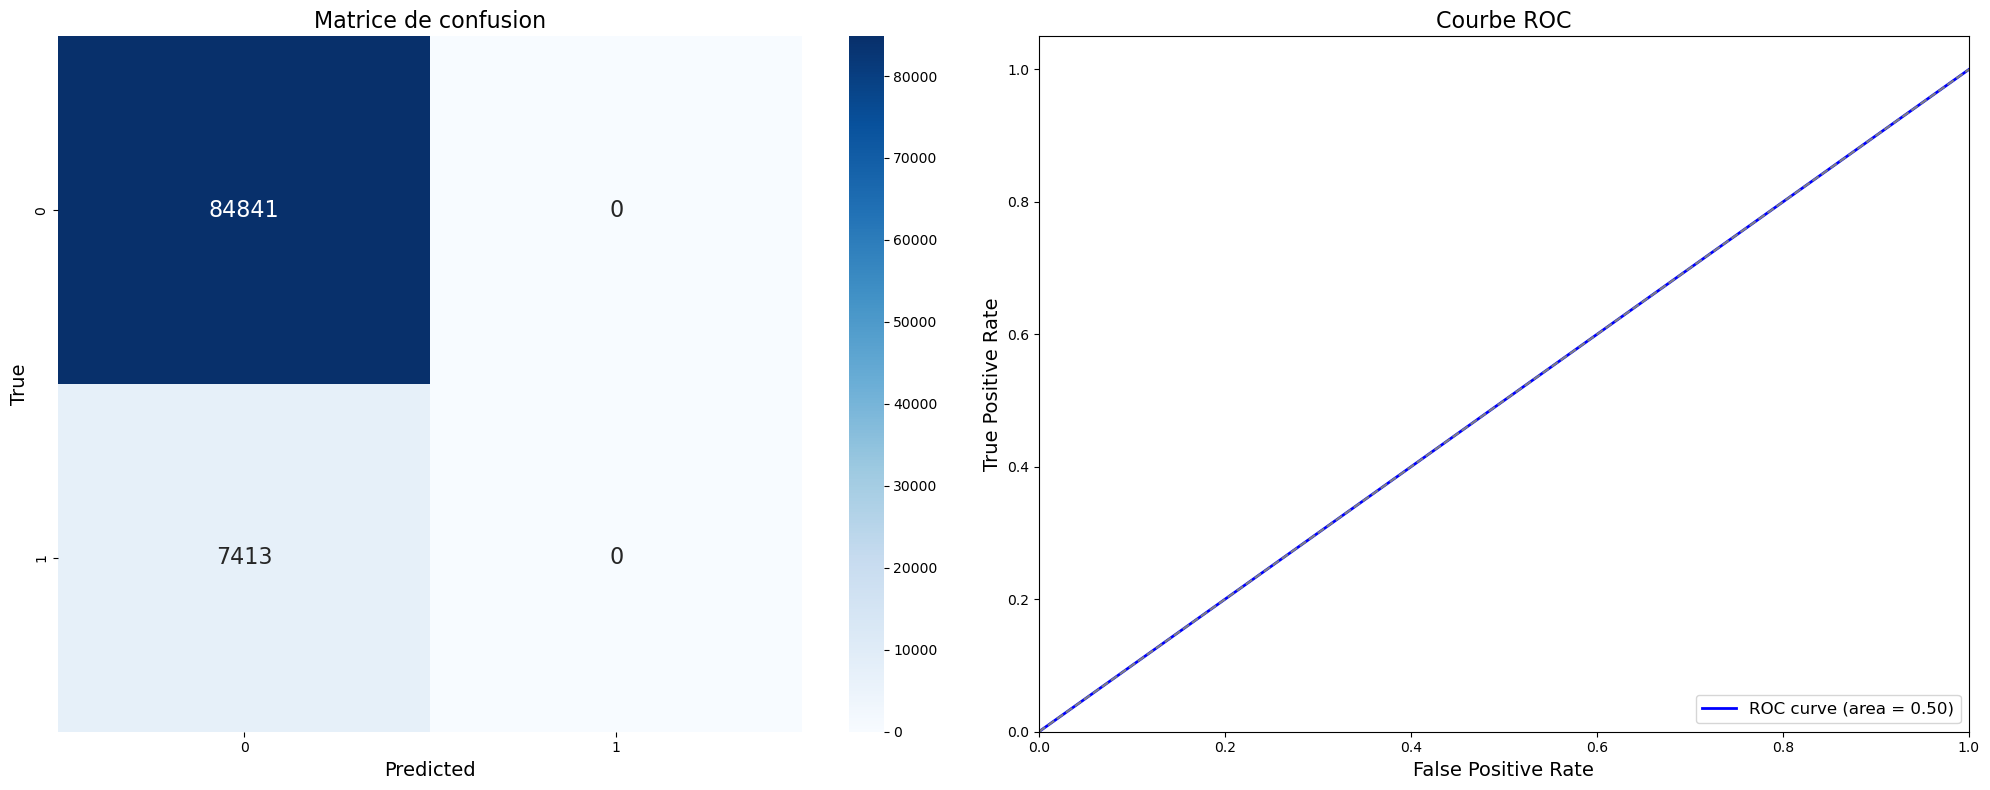

In [20]:
# On va évaluer le modèle sur le test_set et analyser les graphiques
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name, retrain=True, log_to_mlflow=False)

- **AUC_mean** : 0.5  
  Cela indique que le modèle a une performance au niveau du hasard pour la classification binaire. Une AUC de 0.5 signifie que le modèle ne distingue pas mieux entre les classes que si les prédictions étaient aléatoires.

- **Accuracy_mean**
  L'accuracy semble élevée, mais pour un `Dummy Classifier` utilisant la stratégie `most_frequent`, ce score élevé pourrait indiquer que la classe majoritaire occupe une proportion importante dans les données. Cela signifie que le modèle prédit la classe la plus fréquente, ce qui peut donner une apparence trompeusement bonne de performance dans des cas de déséquilibre des classes.

- **Fit_time_mean**   
  Le temps moyen nécessaire pour entraîner le modèle est assez faible, ce qui est attendu car le `Dummy Classifier` est très simple.

- **Score_time_mean**   
  Le temps moyen pour faire des prédictions est aussi très faible, ce qui est normal pour ce type de modèle.

Ces résultats montrent que le `Dummy Classifier` est utile comme point de référence. Un modèle plus sophistiqué devrait idéalement obtenir une AUC plus élevée et être capable de mieux distinguer entre les classes. Les prochaines étapes consisteront probablement à comparer ces résultats avec ceux des modèles plus complexes pour évaluer leur performance relative.

## 2.2 - Régression logistique

La régression logistique est un modèle statistique utilisé principalement pour des tâches de classification binaire. Contrairement à une régression linéaire qui prédit une valeur continue, la régression logistique prédit la probabilité qu'un échantillon appartienne à une classe donnée. En sortie, elle donne des probabilités comprises entre 0 et 1, qui peuvent être ensuite converties en classes (0 ou 1) en fonction d'un seuil.

En tant que premier modèle de base, la régression logistique nous permettra d'établir une baseline pour prédire la probabilité de défaut de paiement. En testant le modèle avant et après l'application de SMOTE, nous allons comparer l'impact du rééquilibrage des classes sur les performances du modèle.
L'application de SMOTE avant l'entraînement d'une régression logistique peut potentiellement améliorer les performances, notamment sur des données déséquilibrées, car elle crée de nouveaux échantillons dans la classe minoritaire.

In [21]:
# On va définir le/les modèle(s)
models = {
    'Régression Logistique': LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
}

Le paramètre `n_jobs` est couramment utilisé dans scikit-learn pour spécifier combien de cœurs de processeur doivent être utilisés pour exécuter les opérations en parallèle. Voici un guide sur comment utiliser `n_jobs` pour accélérer l'entraînement de vos modèles :

- **`n_jobs=-1`** : Utilise **tous** les cœurs disponibles sur votre machine. Cela maximise la parallélisation et peut réduire le temps d'entraînement, surtout si vous travaillez avec de grands ensembles de données.
- **`n_jobs=1`** (ou ne pas spécifier) : Utilise un seul cœur (c'est le comportement par défaut).
- **`n_jobs=N`** : Utilise exactement **N** cœurs de processeur. Par exemple, `n_jobs=4` utilisera 4 cœurs.

In [22]:
# On va entraîner et évaluer le modèle via cross validation sur le train_set
evaluate_models_with_cross_validation(models, X_train_split, y_train_split, log_to_mlflow=True)

Registered model 'Régression Logistique-classification-model' already exists. Creating a new version of this model...
2024/10/03 18:27:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Régression Logistique-classification-model, version 3
Created version '3' of model 'Régression Logistique-classification-model'.
2024/10/03 18:27:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run Régression Logistique at: http://localhost:5000/#/experiments/404984096885784552/runs/9810b9fcf3b74068b256c3589977e44a.
2024/10/03 18:27:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/404984096885784552.
Registered model 'Random Forest-classification-model' already exists. Creating a new version of this model...
2024/10/03 18:29:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random For

,Model,AUC_mean,Accuracy_mean,Fit_time_mean,Score_time_mean
0,Régression Logistique,0.757533,0.919217,23.679881,12.800363
1,Random Forest,0.724335,0.919106,77.096020,20.300458


Évaluation du modèle: Régression Logistique
Accuracy: 0.9201
AUC: 0.7596
Precision: 0.5820
Recall: 0.0201
F1-score: 0.0389

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84734                 107
True Positive                7264                 149


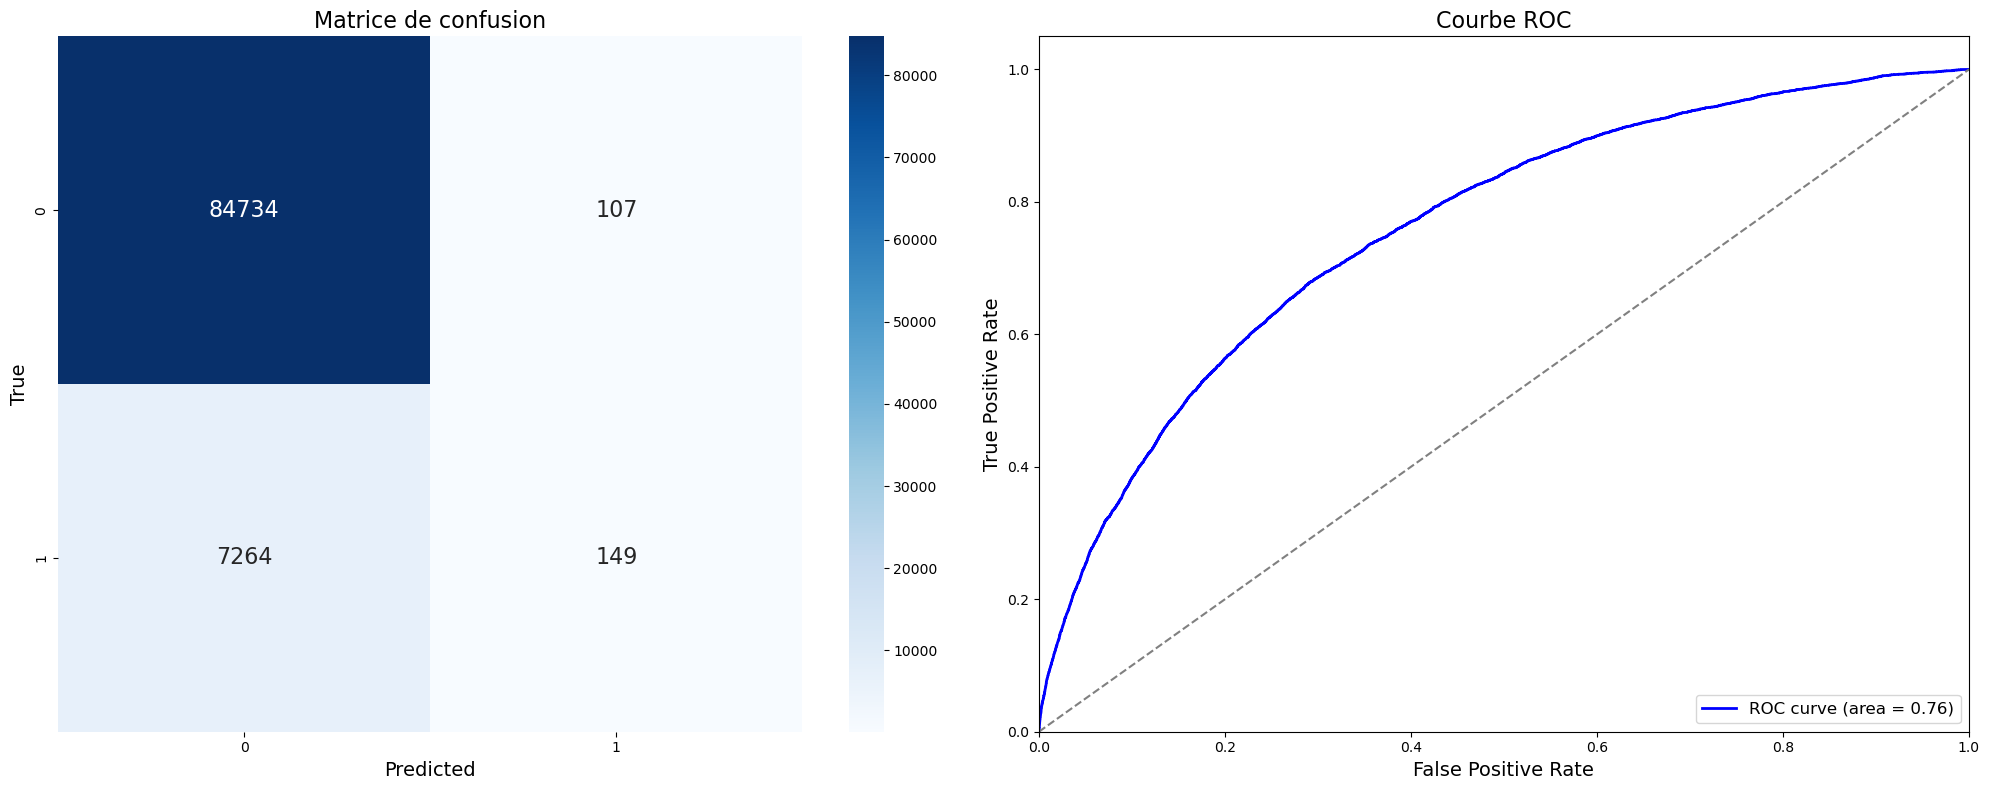

Évaluation du modèle: Random Forest
Accuracy: 0.9197
AUC: 0.7222
Precision: 0.5256
Recall: 0.0111
F1-score: 0.0217

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84767                  74
True Positive                7331                  82


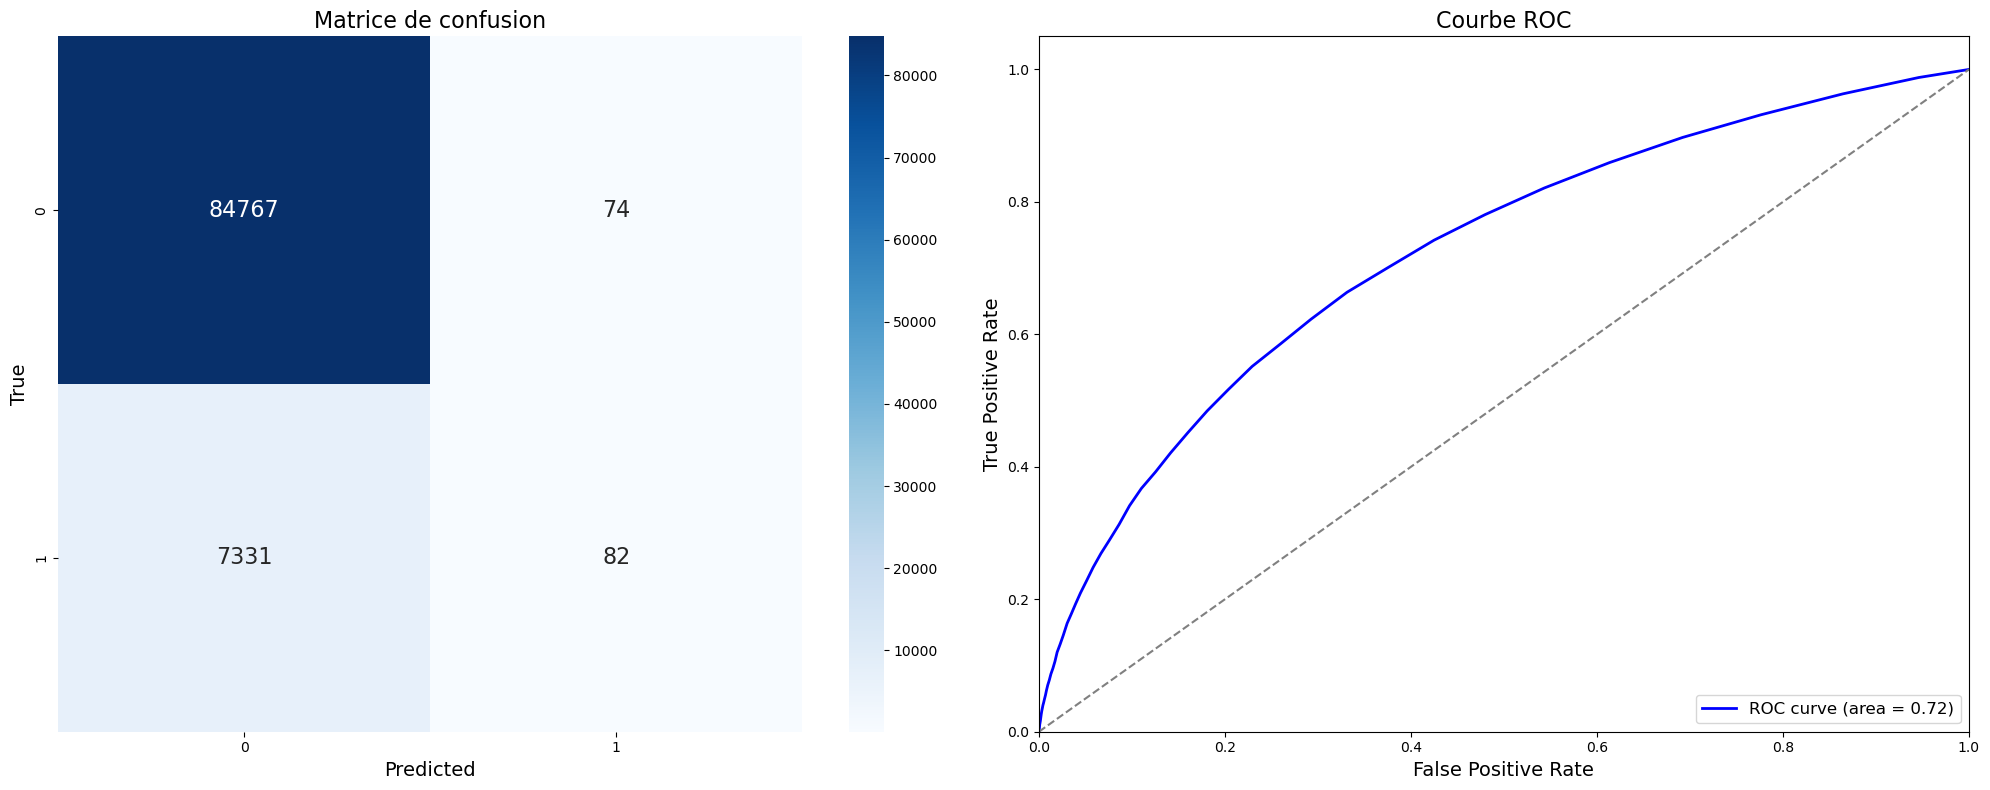

In [23]:
# On va évaluer le modèle sur le test_set et analyser les graphiques
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name, retrain=True, log_to_mlflow=False)

Les résultats de la régression logistique avant l'application de SMOTE montrent des performances satisfaisantes mais trompeuses :

- **AUC_mean** : 0.75 — Cela signifie que le modèle parvient à différencier les classes positives et négatives avec une bonne précision.
- **Accuracy** : 92 % — Le modèle est capable de prédire correctement environ 92 % des exemples.
- **Matrice de confusion** :
  - **True Negative** : Le modèle prédit correctement que 84 730 échantillons n'appartiennent pas à la classe positive.
  - **True Positive** : Seulement 159 échantillons de la classe positive sont correctement prédits.
  - **False Negative** : Il y a un nombre significatif d'échantillons de la classe positive qui sont incorrectement classés comme négatifs.

Nous pouvons analyser cela de la manière suivante :
- **AUC** : le modèle parvient à bien capturer les relations dans les données, mais il pourrait encore être amélioré.
- **Matrice de confusion** : Le nombre élevé de faux négatifs par rapport au nombre relativement faible de vrais positifs est un signe que le modèle a du mal à identifier correctement la classe minoritaire (les défauts de paiement).

Après SMOTE, nous pourrons comparer ces résultats pour évaluer si le rééquilibrage des classes améliore la capacité du modèle à prédire la classe minoritaire. Il serait intéressant de voir si le nombre de vrais positifs augmente après SMOTE, tout en maintenant un bon compromis avec le nombre de faux positifs et la précision globale.

## 2.3 - Gradient Boosting

Le **Gradient Boosting** est une technique de machine learning supervisée utilisée principalement pour les tâches de classification et de régression. Il repose sur l'idée de combiner plusieurs modèles simples (généralement des arbres de décision) pour former un modèle plus performant. Le principe clé du Gradient Boosting est de construire ces modèles séquentiellement, où chaque modèle essaie de corriger les erreurs commises par les modèles précédents. 

Le modèle final est donc une combinaison pondérée de ces modèles faibles, où les modèles successifs "boostent" les performances des précédents en se concentrant sur les observations mal prédictes.

Le **Gradient Boosting** peut être coûteux en termes de calcul et de temps d'entraînement, car il construit les arbres de manière séquentielle. Pour répondre à ce problème, deux algorithmes populaires, **XGBoost** et **LGBM**, ont été développés pour optimiser cette approche.

1. **XGBoost (Extreme Gradient Boosting)**

**XGBoost** est une implémentation optimisée de l'algorithme de Gradient Boosting qui est particulièrement efficace pour les grandes bases de données. Il se distingue par sa rapidité et son efficacité, grâce à plusieurs optimisations importantes :
- **Traitement parallèle** : Contrairement au Gradient Boosting classique qui construit les arbres séquentiellement, XGBoost permet d'entraîner les arbres en parallèle, ce qui réduit considérablement le temps d'exécution.
- **Régularisation** : XGBoost intègre des termes de régularisation (L1 et L2) pour éviter le surapprentissage, en forçant le modèle à être plus simple.
- **Gestion des valeurs manquantes** : XGBoost gère naturellement les données manquantes en apprenant des chemins optimaux pour les valeurs manquantes dans les arbres de décision.


2. **LGBM (LightGBM)**

**LightGBM** est une autre implémentation optimisée du Gradient Boosting, développée par Microsoft. **LGBM** se distingue par sa capacité à traiter de très grands volumes de données de manière encore plus rapide que XGBoost grâce à une approche de construction d'arbres appelée **Leaf-wise Tree Growth** :
- **Growth Leaf-Wise** : Contrairement à XGBoost qui ajoute des niveaux à chaque arbre (Level-wise), LGBM choisit d'ajouter des feuilles uniquement aux branches qui réduisent le plus l'erreur. Cela permet d'obtenir des arbres plus profonds et plus efficaces sans augmenter significativement le coût de calcul.
- **Gestion des grandes bases de données** : LGBM est particulièrement efficace pour des datasets volumineux ou très dimensionnels.
- **Optimisation de la mémoire** : LGBM a été conçu pour être plus économe en mémoire que XGBoost, ce qui est un avantage pour des tâches de grande échelle.

In [24]:
# On va définir le/les modèle(s)
models = {
    'LGBM Classifier': lgb.LGBMClassifier(random_state=42, device='gpu'),
    'XGBoost': xgb.XGBClassifier(random_state=42, tree_method='gpu_hist')
}

In [25]:
# Vérification GPU (XGBoost)
print(f"XGBoost GPU status: {xgb.XGBClassifier(tree_method='gpu_hist').get_xgb_params()}")

XGBoost GPU status: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None}


In [26]:
# Nettoyage des noms de colonnes en supprimant les caractères spéciaux
X_train_split.columns = X_train_split.columns.str.replace(r'[^\w]', '_', regex=True)
#X_train_split_smote.columns = X_train_split_smote.columns.str.replace(r'[^\w]', '_', regex=True)
X_val.columns = X_val.columns.str.replace(r'[^\w]', '_', regex=True)

In [27]:
# On va entraîner et évaluer le modèle via cross validation sur le train_set
evaluate_models_with_cross_validation(models, X_train_split, y_train_split, log_to_mlflow=True)

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 35622
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 332
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 129 dense feature groups (27.10 MB) transferred to GPU in 0.011097 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324


Registered model 'LGBM Classifier-classification-model' already exists. Creating a new version of this model...
2024/10/03 18:30:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBM Classifier-classification-model, version 4
Created version '4' of model 'LGBM Classifier-classification-model'.
2024/10/03 18:30:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run LGBM Classifier at: http://localhost:5000/#/experiments/404984096885784552/runs/f6bd890332664ac1a30f2a9717ec2ef7.
2024/10/03 18:30:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/404984096885784552.
Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 18:31:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 17

,Model,AUC_mean,Accuracy_mean,Fit_time_mean,Score_time_mean
0,LGBM Classifier,0.773640,0.919524,8.062324,2.633710
1,XGBoost,0.762823,0.918279,10.489254,1.775527


Évaluation du modèle: LGBM Classifier
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 35622
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 332
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 129 dense feature groups (27.10 MB) transferred to GPU in 0.010876 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
Accuracy: 0.9202
AUC: 0.7753
Precision: 0.5631
Recall: 0.0301
F1-score: 0.0571

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84668                 173
True Positive

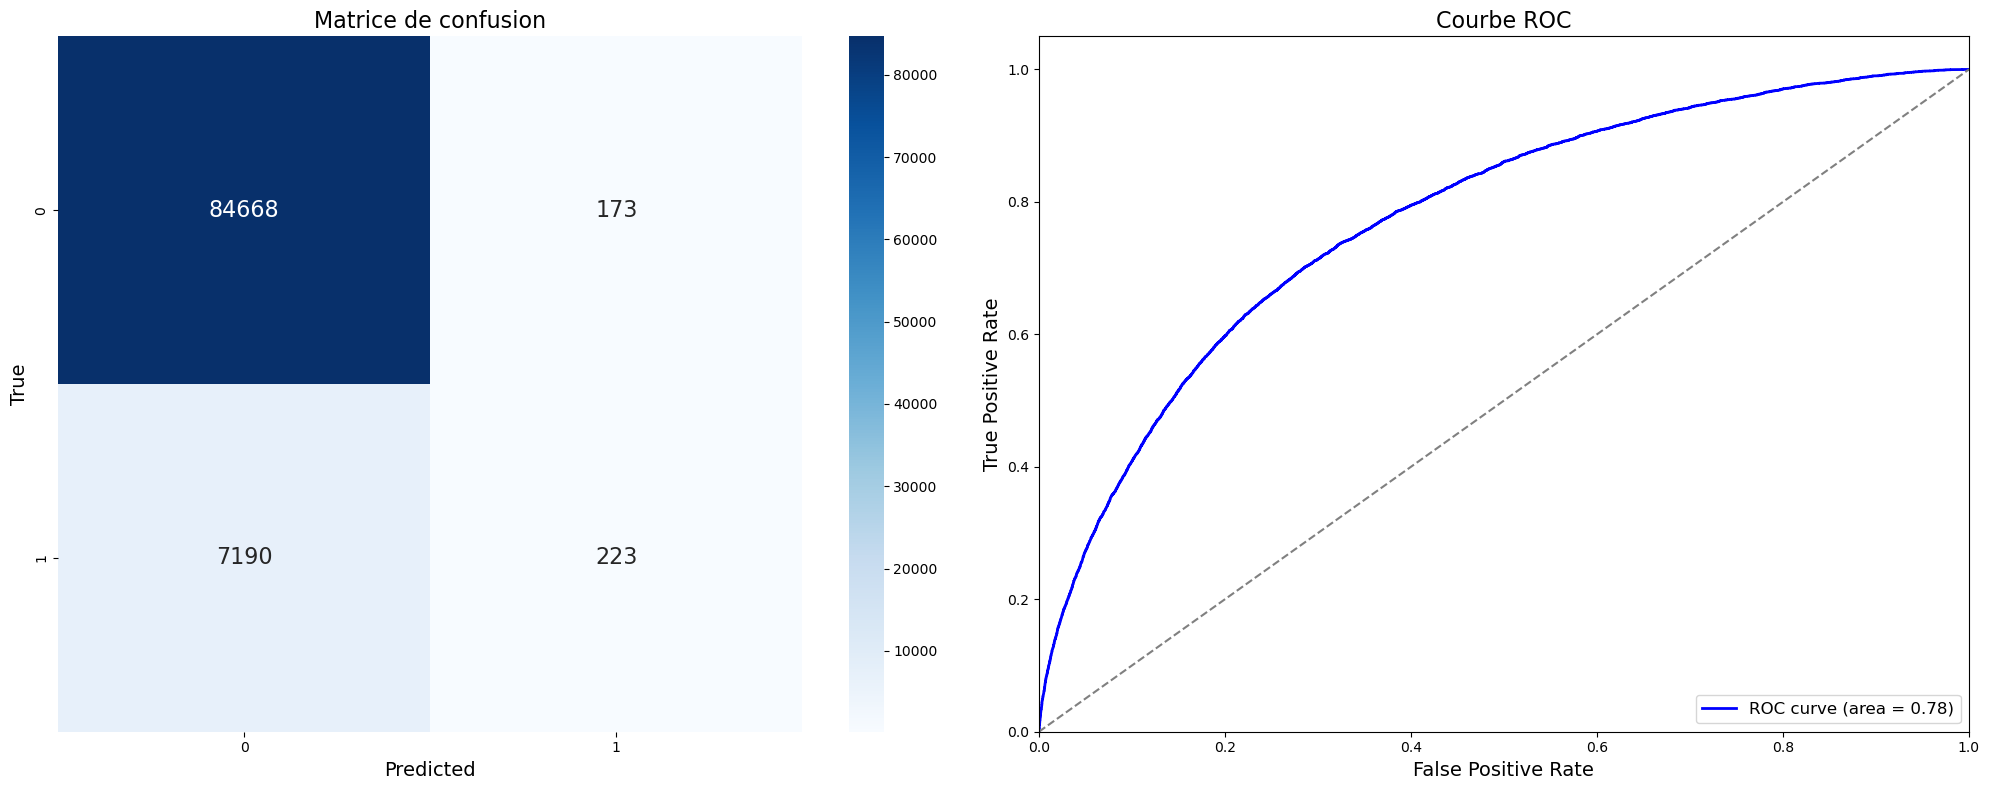

Évaluation du modèle: XGBoost
Accuracy: 0.9191
AUC: 0.7676
Precision: 0.4693
Recall: 0.0546
F1-score: 0.0979

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84383                 458
True Positive                7008                 405


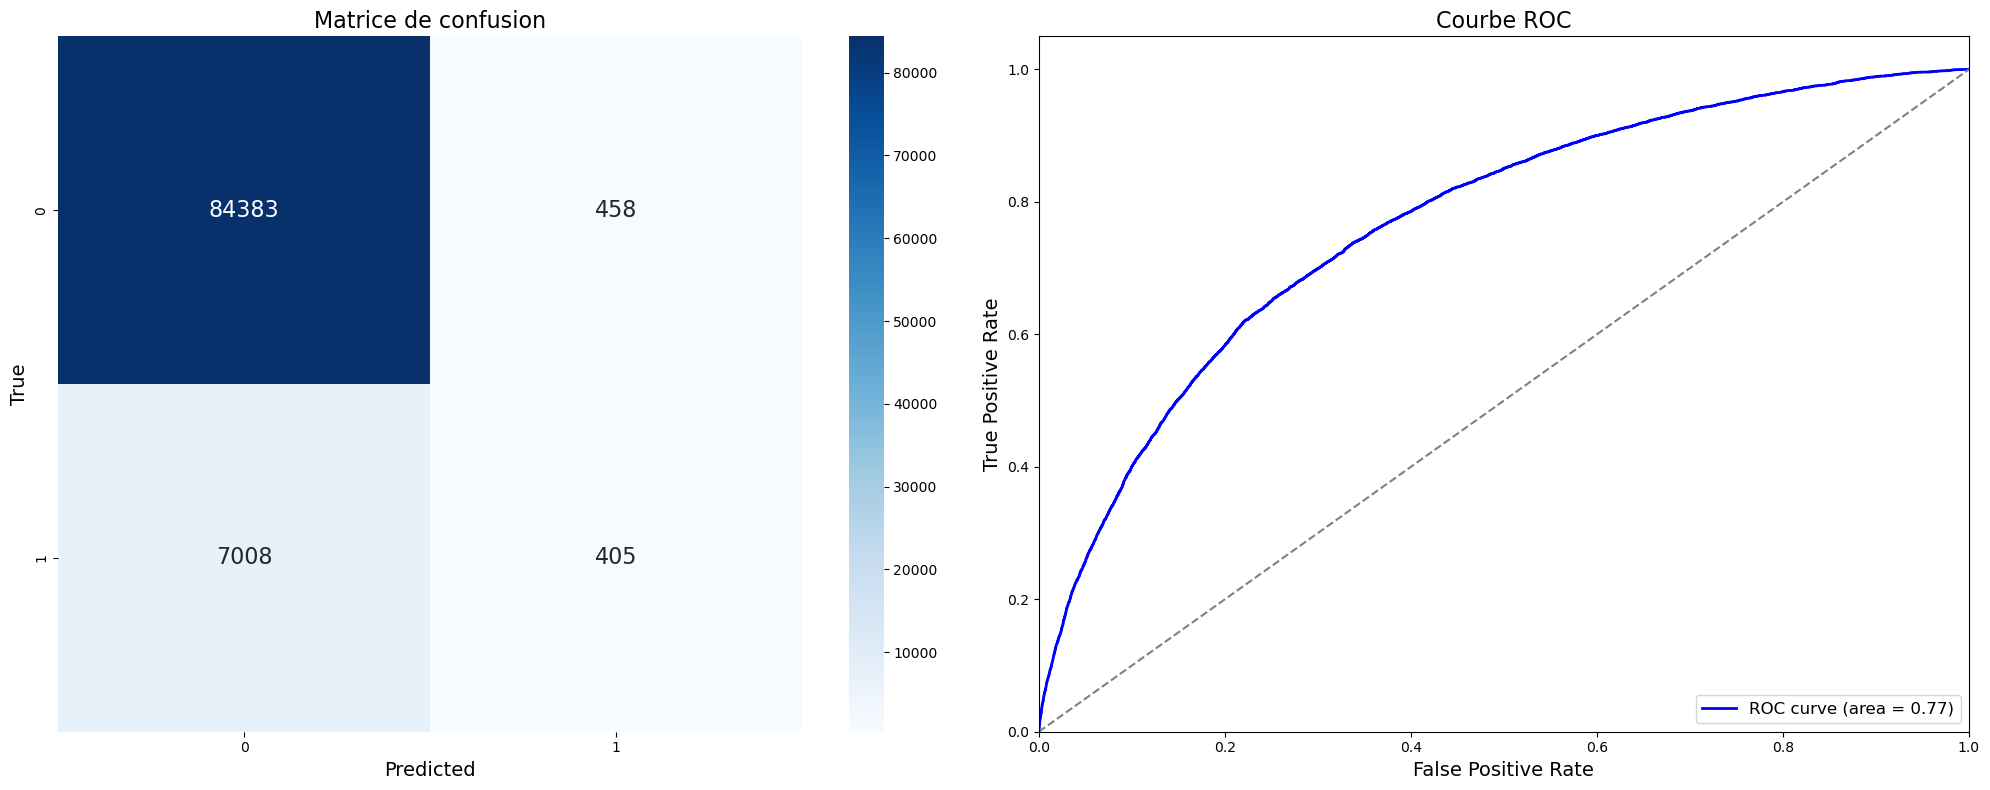

In [28]:
# On va évaluer le modèle sur le test_set et analyser les graphiques
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split, y_train_split, X_val, y_val, model_name, retrain=True, log_to_mlflow=False)

Voici une analyse rapide des résultats obtenus avant l'application de **SMOTE** pour les deux modèles **LGBM Classifier** et **XGBoost** :

**LGBM Classifier :**
- **AUC_mean** : 0.77 – Un score AUC qui montre une bonne capacité de discrimination. Cela indique que le modèle parvient à bien différencier entre les classes positives (clients en défaut) et négatives (clients non en défaut).
- **Accuracy_mean** : 0.91 – Le modèle atteint une très bonne précision, ce qui reflète la proportion de prédictions correctes.
- **Fit_time_mean** : 8.98 secondes – L'entraînement du modèle est assez rapide.
- **Score_time_mean** : 0.1820 seconde – Le temps pour réaliser les prédictions est également très court, ce qui est un atout pour les systèmes de scoring en temps réel.

**XGBoost :**
- **AUC_mean** : 0.76 – Légèrement inférieur à celui de LGBM, mais reste un score solide qui montre une bonne capacité de discrimination.
- **Accuracy_mean** : 0.91 – Un peu plus bas que LGBM, mais reste très élevé et performant.
- **Fit_time_mean** : 13.12 secondes – L'entraînement de XGBoost est un peu plus long que celui de LGBM, ce qui est habituel étant donné l'approche plus intensive de XGBoost.
- **Score_time_mean** : 0.4146 seconde – Le temps de prédiction est environ deux fois plus long que LGBM, mais reste raisonnable pour des systèmes de production.

**Comparaison globale :**
- **Performance** : LGBM affiche de meilleures performances en termes de score AUC et de précision, bien que les deux modèles soient assez proches.
- **Temps d'exécution** : LGBM est plus rapide à l'entraînement et pour la prédiction, ce qui peut en faire un candidat plus efficace dans des contextes où la rapidité est cruciale.

# 3 - Deuxième modélisation : après SMOTE

L'utilisation de **SMOTE** (*Synthetic Minority Over-sampling Technique*) est particulièrement utile lorsque l'on travaille avec des ensembles de données déséquilibrés. En data science, un ensemble de données est dit déséquilibré lorsque la répartition des classes dans la variable cible n'est pas équilibrée, c'est-à-dire que l'une des classes (par exemple, les cas de défaut de paiement) est beaucoup moins représentée que l'autre (les non-défauts).

**Pourquoi utiliser SMOTE ?**

1. **Déséquilibre des classes** : Lorsque les classes sont déséquilibrées, les algorithmes de machine learning ont tendance à biaiser leurs prédictions en faveur de la classe majoritaire. Par exemple, dans le cas d’un modèle de scoring de crédit, si les défauts de paiement (classe minoritaire) représentent seulement 5 % des observations, un modèle pourrait simplement prédire que tout le monde remboursera son prêt pour obtenir une haute précision (en ignorant totalement les 5 % de défauts).
   
2. **SMOTE pour rééquilibrer les classes** : SMOTE génère de nouvelles observations synthétiques pour la classe minoritaire en combinant plusieurs exemples existants proches dans l’espace des caractéristiques. Cela permet de rééquilibrer le jeu de données sans simplement dupliquer les observations, ce qui pourrait mener à de l'overfitting.

3. **Amélioration des performances du modèle** :
   - **Meilleure sensibilité aux classes minoritaires** : Grâce à SMOTE, notre modèle pourra mieux identifier les cas appartenant à la classe minoritaire (dans notre cas, les clients à risque de défaut de paiement).
   - **Précision des prédictions** : Cela évite au modèle de donner une précision trompeuse en prédisant principalement la classe majoritaire. L'utilisation de métriques comme l'**AUC-ROC** ou le **F1-Score** devient également plus pertinente car elles tiennent compte des performances sur les deux classes.
   
4. **Limitation du biais du modèle** : Sans une correction comme SMOTE, le modèle risque de négliger la classe minoritaire et de mal gérer les faux négatifs (prédire qu'un client remboursera alors qu'il va faire défaut). Dans le contexte d'un modèle de scoring crédit, cela peut avoir des conséquences importantes sur le coût métier.

**Comment fonctionne SMOTE ?**

SMOTE fonctionne en trois étapes :
1. **Sélection des points de la classe minoritaire**.
2. **Création des observations synthétiques** : Pour chaque point de la classe minoritaire, SMOTE sélectionne les k plus proches voisins (en général 5). Ensuite, il génère un point synthétique sur la ligne qui relie l'exemple de la classe minoritaire sélectionné et l'un de ses voisins.
3. **Ajout des nouvelles données au jeu d'entraînement** : Les observations synthétiques sont ajoutées au jeu d'entraînement, augmentant la proportion de la classe minoritaire.

In [29]:
# On va commencer par initialiser notre expérimentation MLFlow
mlflow.set_experiment("2 - Deuxième modélisation : après SMOTE")

<Experiment: artifact_location='mlflow-artifacts:/755173642422949213', creation_time=1727967034502, experiment_id='755173642422949213', last_update_time=1727967034502, lifecycle_stage='active', name='2 - Deuxième modélisation : après SMOTE', tags={}>

## 3.1 - Application du SMOTE

In [30]:
# Avant SMOTE
print("Répartition des classes avant SMOTE :")
print(pd.Series(y_train_split).value_counts())

# Application de SMOTE
smote = SMOTE(random_state=42)
X_train_split_smote, y_train_split_smote = smote.fit_resample(X_train_split, y_train_split)

# Après SMOTE
print("\nRépartition des classes après SMOTE :")
print(pd.Series(y_train_split_smote).value_counts())

Répartition des classes avant SMOTE :
TARGET
0.0    197845
1.0     17412
Name: count, dtype: int64

Répartition des classes après SMOTE :
TARGET
0.0    197845
1.0    197845
Name: count, dtype: int64


## 3.2 - Entraînement des modèles

Nous allons tester les 4 modèles précédents après application de SMOTE puis comparer nos résultats.

Tester un Dummy Classifier après avoir appliqué SMOTE peut être intéressant dans certains cas, mais il faut garder à l’esprit que cela n'a pas de réel sens pratique dans un projet de modélisation. Pourquoi ?

- **SMOTE** est une méthode utilisée pour équilibrer les classes dans les jeux de données déséquilibrés en générant des échantillons synthétiques pour la classe minoritaire.
- Le **Dummy Classifier**, en revanche, est un modèle très basique qui fait des prédictions triviales (par exemple, prédire la classe majoritaire ou une prédiction aléatoire).

Ce qui pourrait arriver ?
- Après SMOTE, notre jeu de données d'entraînement sera équilibré, mais un Dummy Classifier qui utilise la stratégie "Most Frequent" ne fera que prédire les classes en fonction de la distribution originale. Si les classes sont équilibrées, ce classifieur pourrait prédire aléatoirement.
- **Résultat attendu** : Le Dummy Classifier après SMOTE pourrait avoir un score AUC ou une accuracy proches de 0.5, car il ferait des prédictions quasi-aléatoires dans un contexte où les classes sont équilibrées.

Pourquoi le tester ?
Tester un Dummy Classifier après SMOTE permet d’avoir un repère pour vérifier si les modèles plus avancés (comme ceux basés sur des algorithmes de boosting ou de régression logistique) apportent une réelle valeur ajoutée par rapport à un modèle trivial.

In [31]:
# On va définir le/les modèle(s)
models = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent'),
    'Régression Logistique': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1, ),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1),
    'LGBM Classifier': lgb.LGBMClassifier(random_state=42, device='gpu'),
    'XGBoost': xgb.XGBClassifier(random_state=42, tree_method='gpu_hist')
}

In [32]:
# On va entraîner et évaluer le modèle via cross validation sur le train_set
evaluate_models_with_cross_validation(models, X_train_split_smote, y_train_split_smote, log_to_mlflow=True)

Registered model 'Dummy Classifier-classification-model' already exists. Creating a new version of this model...
2024/10/03 18:33:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Dummy Classifier-classification-model, version 4
Created version '4' of model 'Dummy Classifier-classification-model'.
2024/10/03 18:33:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Classifier at: http://localhost:5000/#/experiments/755173642422949213/runs/ba2b7f3120564045bebf7aca6948260b.
2024/10/03 18:33:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/755173642422949213.
Registered model 'Régression Logistique-classification-model' already exists. Creating a new version of this model...
2024/10/03 18:37:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Régression Logistique-

[LightGBM] [Info] Number of positive: 197845, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 75744
[LightGBM] [Info] Number of data points in the train set: 395690, number of used features: 335
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 143 dense feature groups (54.34 MB) transferred to GPU in 0.017872 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Registered model 'LGBM Classifier-classification-model' already exists. Creating a new version of this model...
2024/10/03 18:43:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBM Classifier-classification-model, version 5
Created version '5' of model 'LGBM Classifier-classification-model'.
2024/10/03 18:43:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run LGBM Classifier at: http://localhost:5000/#/experiments/755173642422949213/runs/ca573f13579545afba4c61b18502ca2a.
2024/10/03 18:43:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/755173642422949213.
Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 18:45:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 18

,Model,AUC_mean,Accuracy_mean,Fit_time_mean,Score_time_mean
0,Dummy Classifier,0.500000,0.500000,2.780510,0.012000
1,Régression Logistique,0.792890,0.722237,117.331461,78.713926
2,Random Forest,0.978848,0.945826,150.587622,39.604113
3,LGBM Classifier,0.925267,0.953694,16.616741,4.290937
4,XGBoost,0.927798,0.951048,21.367575,4.010326


## 3.3 - Evaluation du modèle

Évaluation du modèle: Dummy Classifier
Accuracy: 0.9196
AUC: 0.5000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84841                   0
True Positive                7413                   0


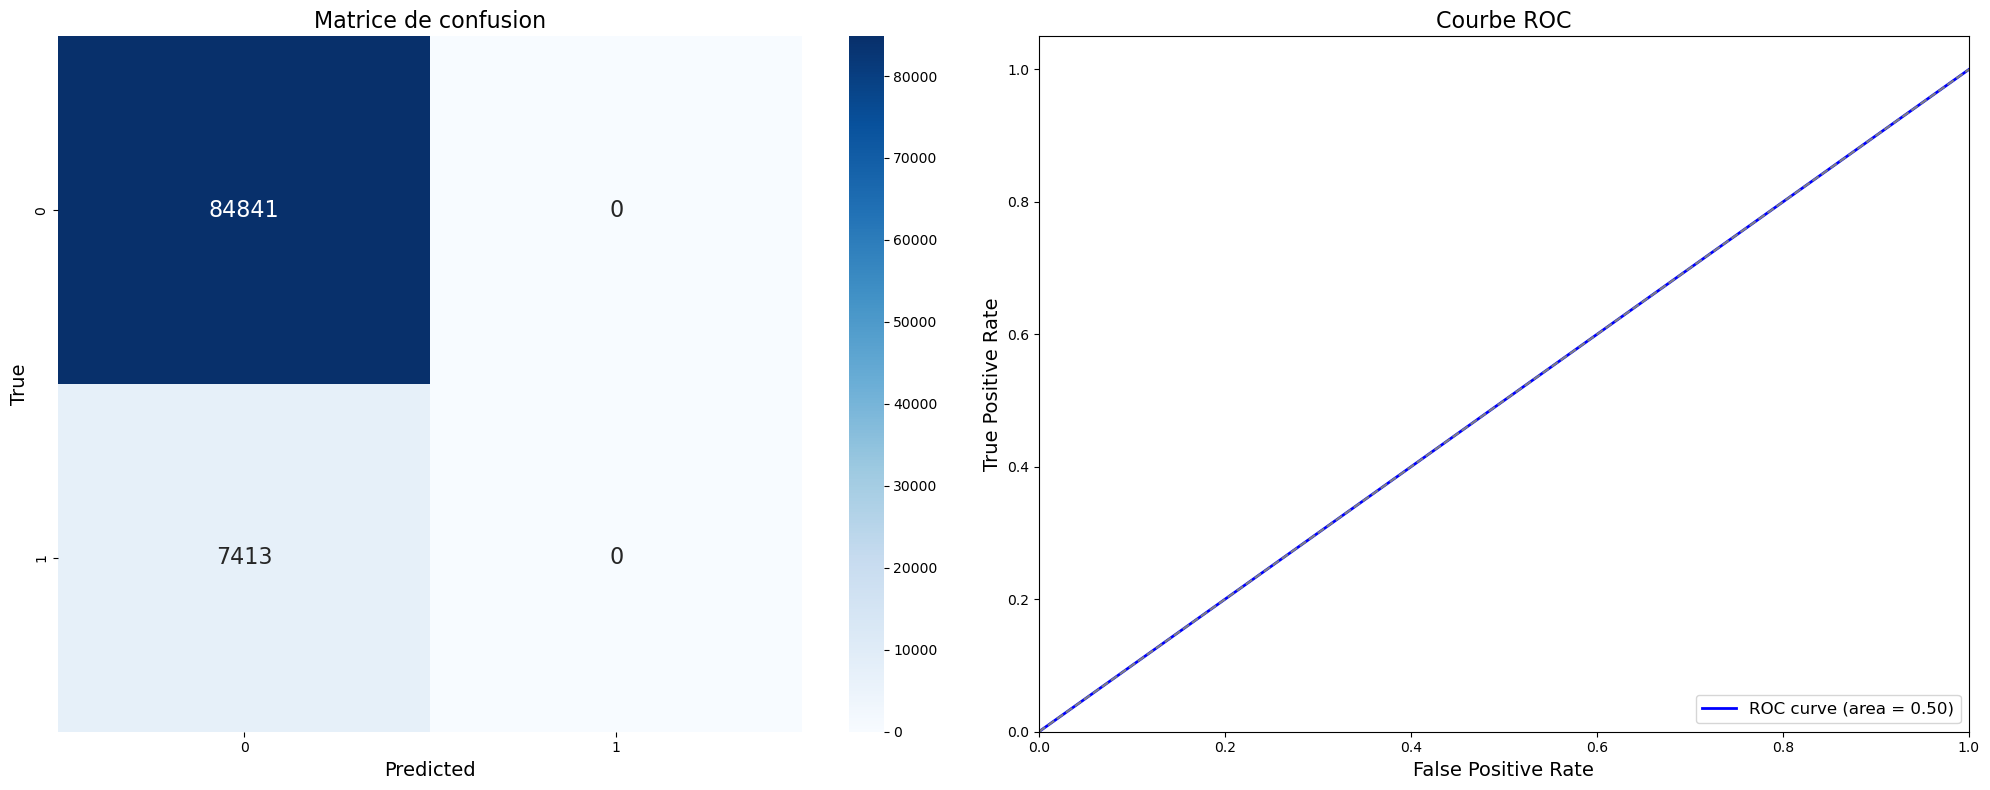

Évaluation du modèle: Régression Logistique
Accuracy: 0.7053
AUC: 0.7529
Precision: 0.1661
Recall: 0.6633
F1-score: 0.2656

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               60152               24689
True Positive                2496                4917


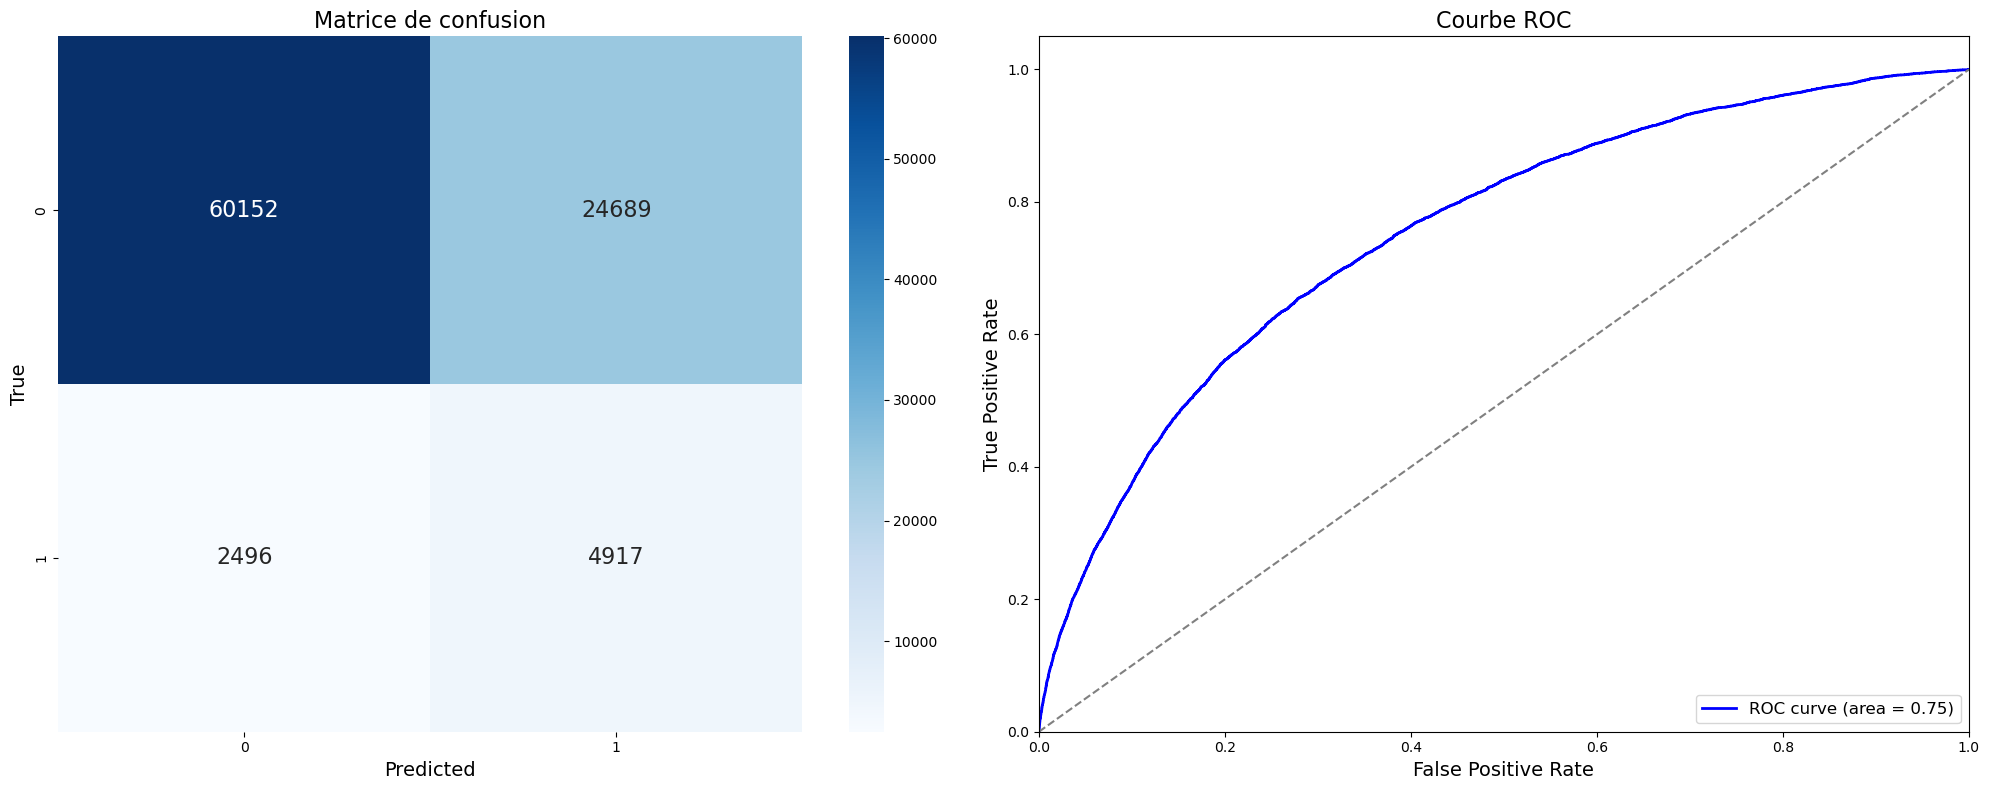

Évaluation du modèle: Random Forest
Accuracy: 0.9087
AUC: 0.7170
Precision: 0.2539
Recall: 0.0701
F1-score: 0.1099

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               83313                1528
True Positive                6893                 520


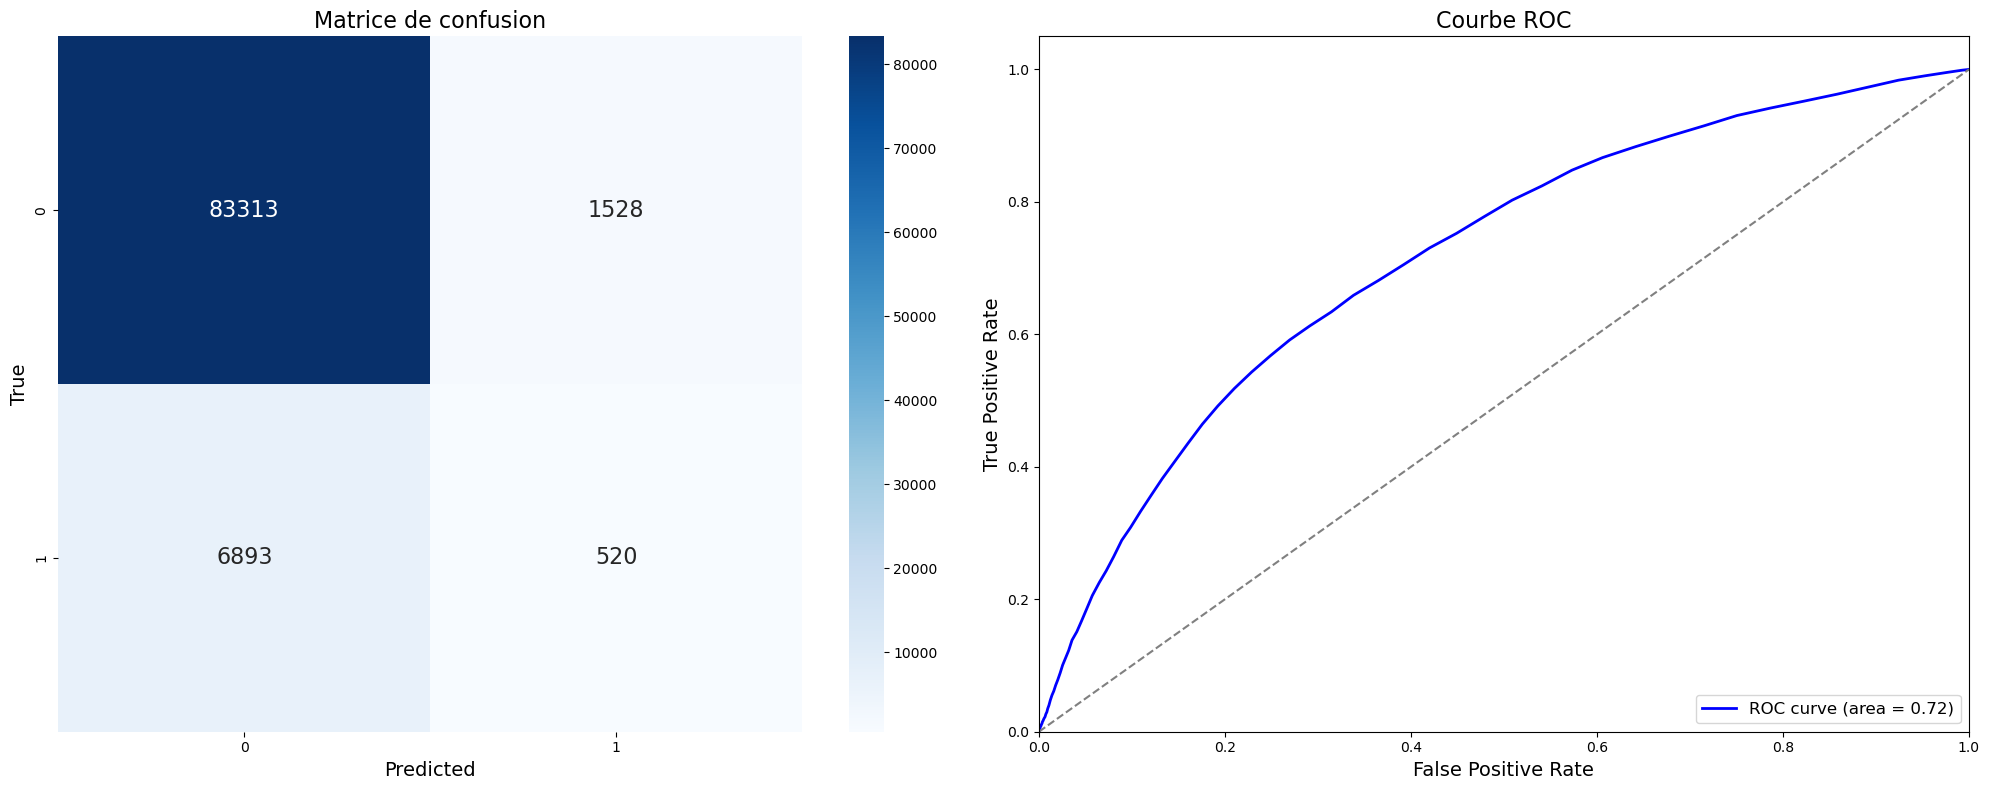

Évaluation du modèle: LGBM Classifier
[LightGBM] [Info] Number of positive: 197845, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 75744
[LightGBM] [Info] Number of data points in the train set: 395690, number of used features: 335
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 143 dense feature groups (54.34 MB) transferred to GPU in 0.017703 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.9192
AUC: 0.7575
Precision: 0.4332
Recall: 0.0179
F1-score: 0.0345

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84667                 174
True Positive                7280                 133


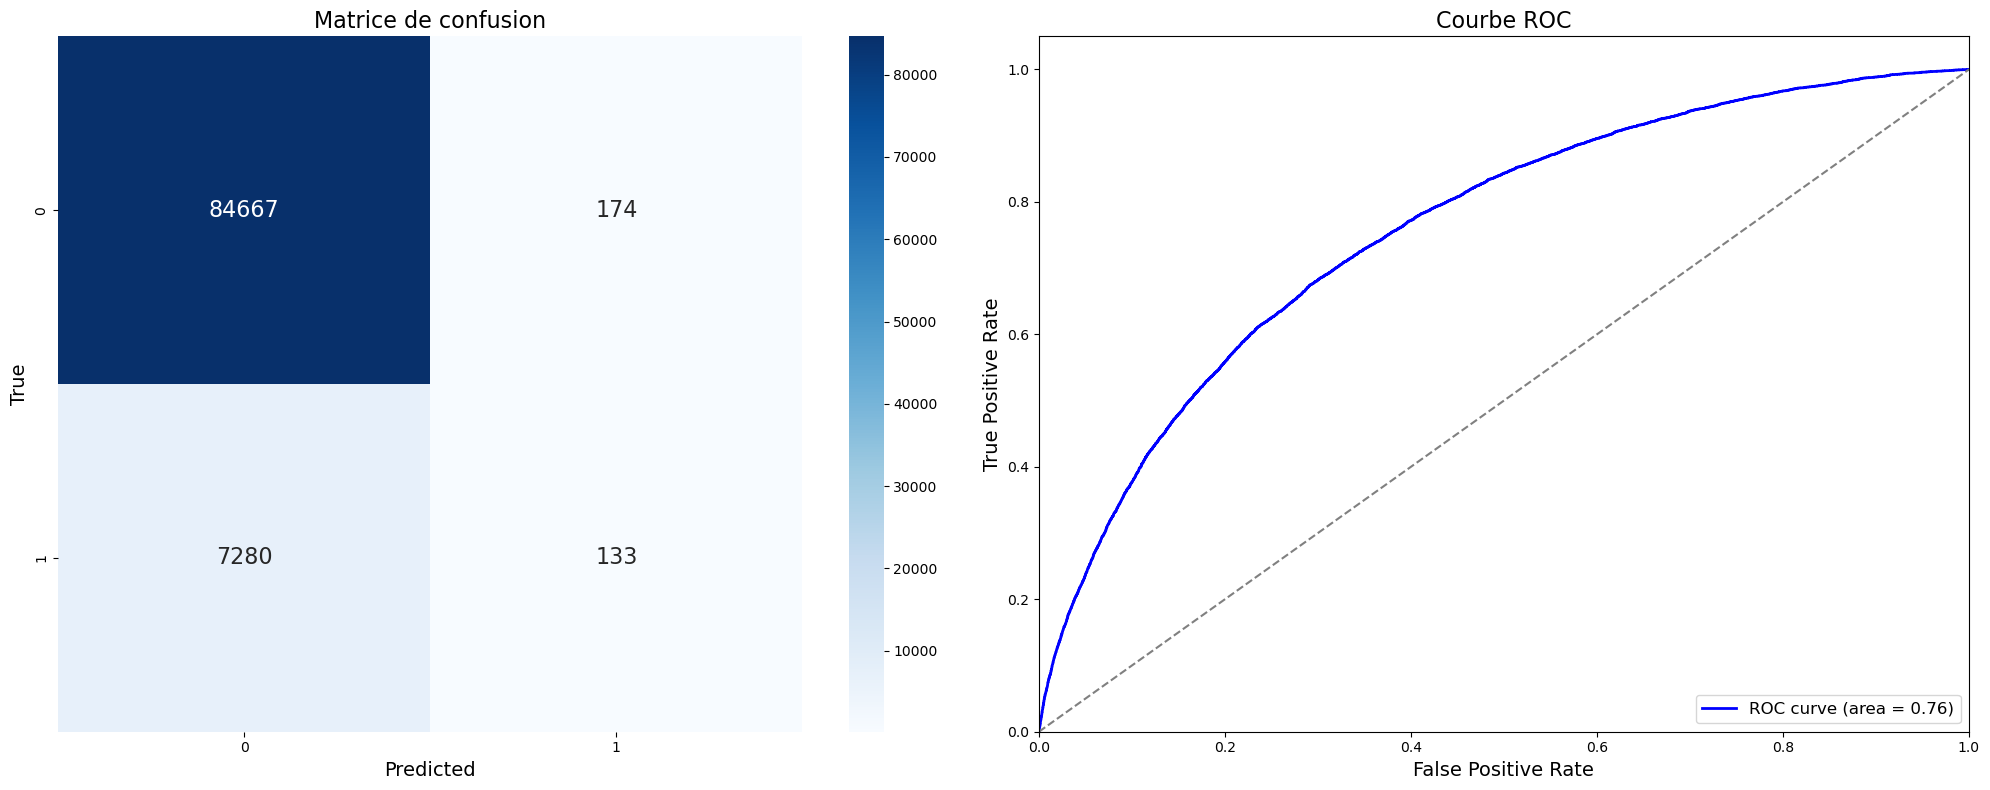

Évaluation du modèle: XGBoost
Accuracy: 0.9182
AUC: 0.7578
Precision: 0.4339
Recall: 0.0584
F1-score: 0.1030

Matrice de confusion :
               Predicted Negative  Predicted Positive
True Negative               84276                 565
True Positive                6980                 433


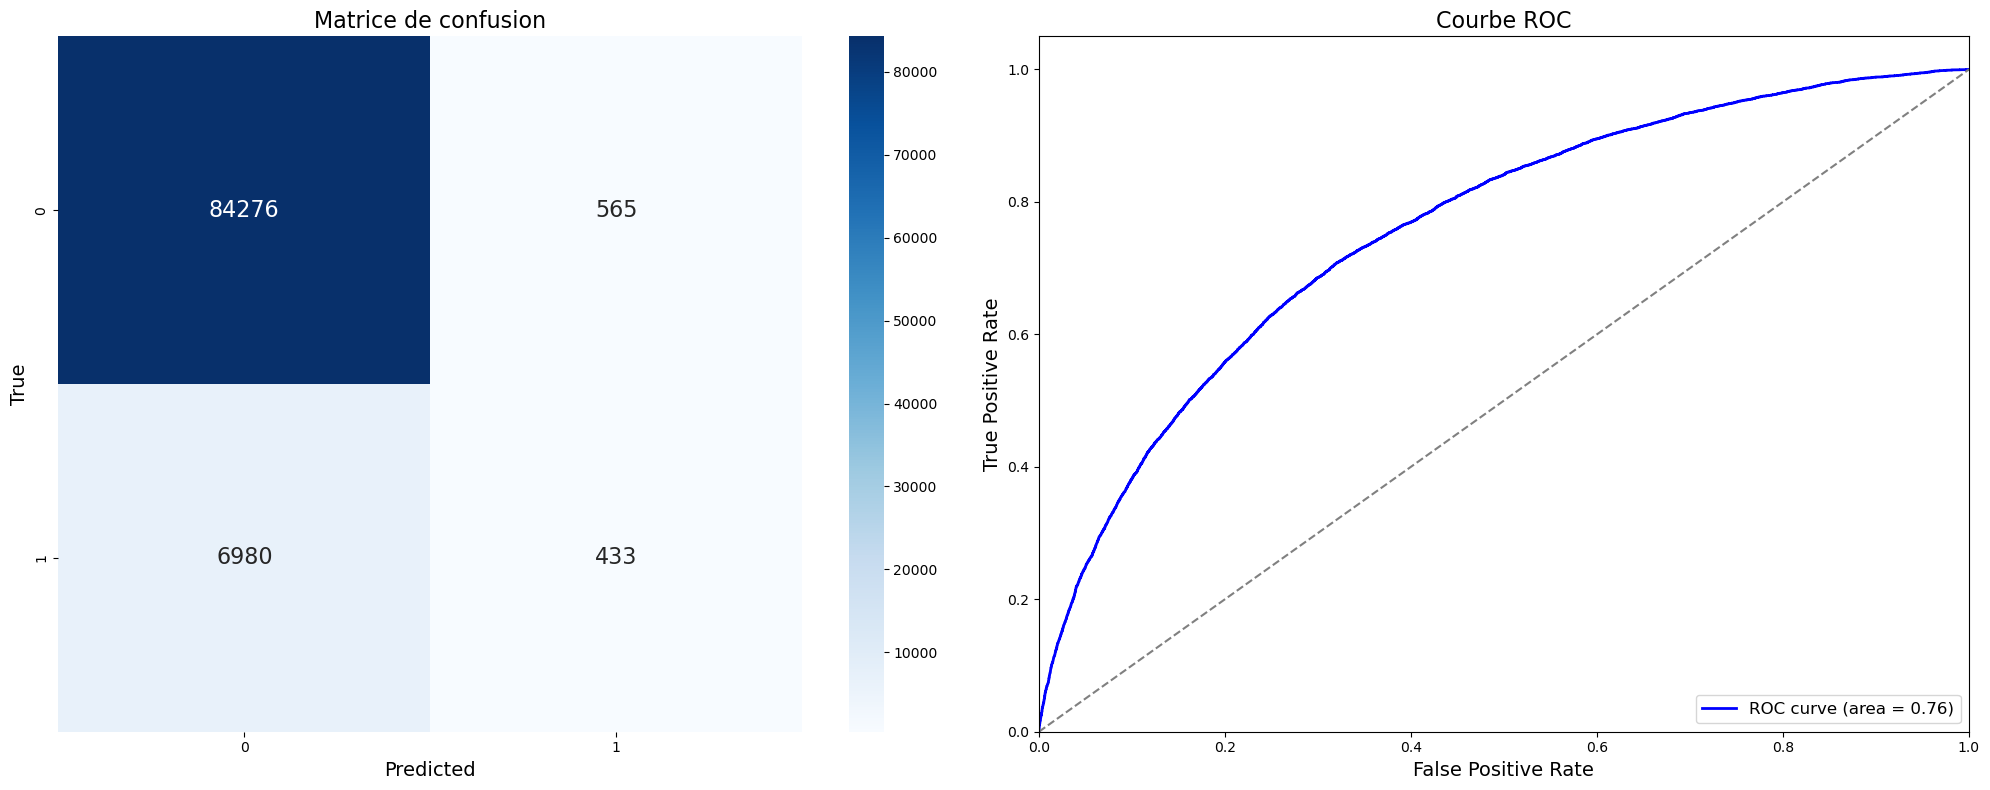

In [33]:
# On va évaluer le modèle sur le test_set et analyser les graphiques
for model_name, model in models.items():
    print(f"Évaluation du modèle: {model_name}")
    evaluate_model(model, X_train_split_smote, y_train_split_smote, X_val, y_val, model_name, retrain=True, log_to_mlflow=False)

Les résultats que nousu obtenons pour le **Dummy Classifier** après avoir appliqué SMOTE montrent un écart important entre l'accuracy moyenne pendant l'entraînement et l'accuracy sur le jeu de test. 

1. **Accuracy élevée sur le jeu de test** :
   - L'accuracy suggère que le modèle prédit la classe majoritaire (negative) pour la quasi-totalité des échantillons du jeu de test. 
   - Cette accuracy élevée est trompeuse car le modèle ne capture aucune information utile, comme le montre la **matrice de confusion** : toutes les prédictions sont dans la classe "Predicted Negative".
   - **Pourquoi ?** Le Dummy Classifier avec SMOTE prédit probablement la classe majoritaire (ou aléatoirement), mais le jeu de test reste déséquilibré, donc la majorité des échantillons appartiennent à la classe majoritaire. C'est pourquoi il semble obtenir une bonne accuracy.

2. **Matrice de confusion** :
   - La matrice de confusion montre clairement que le Dummy Classifier ne prédit jamais la classe positive (aucune prédiction correcte pour les `True Positive`).
   - Cela confirme que le modèle est trivial et n’apporte aucune valeur dans ce contexte, malgré une bonne accuracy apparente.


Ces résultats confirment que **le Dummy Classifier ne tire pas profit du rééquilibrage SMOTE**, et bien que l'accuracy puisse sembler bonne sur le jeu de test, elle n’est pas un indicateur pertinent ici. Il est important de se concentrer sur d’autres métriques comme le **AUC-ROC** ou la **précision sur la classe minoritaire** pour mieux évaluer les modèles dans des situations de classes déséquilibrées.

Les résultats de la **régression logistique** avant l'application de SMOTE montrent des performances satisfaisantes mais trompeuses :

- **AUC_mean** : 0.75 — Cela signifie que le modèle parvient à différencier les classes positives et négatives avec une bonne précision.
- **Accuracy** : 92 % — Le modèle est capable de prédire correctement environ 92 % des exemples.
- **Matrice de confusion** :
  - **True Negative** : Le modèle prédit correctement que 84 730 échantillons n'appartiennent pas à la classe positive.
  - **True Positive** : Seulement 159 échantillons de la classe positive sont correctement prédits.
  - **False Negative** : Il y a un nombre significatif d'échantillons de la classe positive qui sont incorrectement classés comme négatifs.

Nous pouvons analyser cela de la manière suivante :
- **AUC** : le modèle parvient à bien capturer les relations dans les données, mais il pourrait encore être amélioré.
- **Matrice de confusion** : Le nombre élevé de faux négatifs par rapport au nombre relativement faible de vrais positifs est un signe que le modèle a du mal à identifier correctement la classe minoritaire (les défauts de paiement).

Après SMOTE, nous pourrons comparer ces résultats pour évaluer si le rééquilibrage des classes améliore la capacité du modèle à prédire la classe minoritaire. Il serait intéressant de voir si le nombre de vrais positifs augmente après SMOTE, tout en maintenant un bon compromis avec le nombre de faux positifs et la précision globale.

Voici une analyse rapide des résultats obtenus avant l'application de **SMOTE** pour les deux modèles **LGBM Classifier** et **XGBoost** :

**LGBM Classifier :**
- **AUC_mean** : 0.7731 – Un score AUC qui montre une bonne capacité de discrimination. Cela indique que le modèle parvient à bien différencier entre les classes positives (clients en défaut) et négatives (clients non en défaut).
- **Accuracy_mean** : 0.9195 – Le modèle atteint une très bonne précision, ce qui reflète la proportion de prédictions correctes.
- **Fit_time_mean** : 8.98 secondes – L'entraînement du modèle est assez rapide.
- **Score_time_mean** : 0.1820 seconde – Le temps pour réaliser les prédictions est également très court, ce qui est un atout pour les systèmes de scoring en temps réel.

**XGBoost :**
- **AUC_mean** : 0.7642 – Légèrement inférieur à celui de LGBM, mais reste un score solide qui montre une bonne capacité de discrimination.
- **Accuracy_mean** : 0.9180 – Un peu plus bas que LGBM, mais reste très élevé et performant.
- **Fit_time_mean** : 13.12 secondes – L'entraînement de XGBoost est un peu plus long que celui de LGBM, ce qui est habituel étant donné l'approche plus intensive de XGBoost.
- **Score_time_mean** : 0.4146 seconde – Le temps de prédiction est environ deux fois plus long que LGBM, mais reste raisonnable pour des systèmes de production.

**Comparaison globale :**
- **Performance** : LGBM affiche de meilleures performances en termes de score AUC et de précision, bien que les deux modèles soient assez proches.
- **Temps d'exécution** : LGBM est plus rapide à l'entraînement et pour la prédiction, ce qui peut en faire un candidat plus efficace dans des contextes où la rapidité est cruciale.

# 4 - Recherche des meilleurs hyperparamètres

L'objectif principal maintenant est d'optimiser les performances des modèles choisis via le **réglage des hyperparamètres**. Pour ce faire, il serait plus efficace de procéder à une **recherche d'hyperparamètres (Grid Search ou Random Search)** combinée avec une validation croisée.

- **Pourquoi faire une validation croisée ici ?**
  - La validation croisée (CV) lors du réglage des hyperparamètres garantit l'évaluation des performances du modèle sur différentes portions du dataset, limitant ainsi les risques de surapprentissage (overfitting) sur une seule partition des données.
  - Cela est surtout important pour éviter que le modèle soit trop optimisé pour une seule division du train-test split.

Une fois que nous aurons les **meilleurs hyperparamètres** pour notre modèle, nous pourrons passer à l'étape d'élaboration du **score métier**. Cette étape peut se faire après le réglage des hyperparamètres et sur une seule division de train-test (sans validation croisée répétée), car nous nous focaliserons sur l'évaluation des **coûts associés aux erreurs de prédiction** (faux positifs et faux négatifs), en fonction des besoins spécifiques du métier.

In [34]:
# On va commencer par initialiser notre expérimentation MLFlow
mlflow.set_experiment("3 - Hyperparameter Tuning")

<Experiment: artifact_location='mlflow-artifacts:/723469373659716953', creation_time=1727967971830, experiment_id='723469373659716953', last_update_time=1727967971830, lifecycle_stage='active', name='3 - Hyperparameter Tuning', tags={}>

## 4.1 - LGBM Classifier

Dans cette section, nous procédons à l'optimisation des hyperparamètres de notre modèle de LightGBM afin d'améliorer ses performances. L'optimisation des hyperparamètres est une étape importante dans le développement d'un modèle machine learning, car elle permet d'ajuster les paramètres du modèle pour maximiser les performances sur un ensemble de validation.

Pour ce faire, nous avons utilisé une méthode de **RandomizedSearchCV**, qui permet d'explorer un ensemble prédéfini d'hyperparamètres de manière aléatoire, tout en effectuant une validation croisée (cross-validation) sur chaque combinaison d'hyperparamètres. Cela permet de limiter le temps de calcul tout en cherchant les meilleures combinaisons de paramètres.

L'objectif principal est d'optimiser des hyperparamètres tels que :
- `num_leaves` : contrôle la complexité de l'arbre.
- `max_depth` : limite la profondeur de chaque arbre.
- `learning_rate` : détermine la vitesse d'apprentissage du modèle.
- `n_estimators` : contrôle le nombre d'arbres.
- `min_child_samples` : spécifie le nombre minimum d'échantillons dans une feuille.

À l'aide de cette approche, nous cherchons à maximiser le score AUC, une métrique clé pour les problèmes de classification déséquilibrés. Après cette étape, nous utiliserons les meilleurs hyperparamètres pour ajuster notre modèle final et procéder à l'évaluation sur les données de test.

In [35]:
# Grille d'hyperparamètres à tester
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [20, 30, 50]
}

model = lgb.LGBMClassifier(random_state=42, device='gpu')

# Initialisation de RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_grid, 
                                   scoring={'roc_auc': 'roc_auc', 'accuracy': 'accuracy'},
                                   refit='roc_auc',
                                   cv=5, 
                                   n_iter=50,  # Nombre d'itérations à tester
                                   n_jobs=-1, 
                                   verbose=3, 
                                   random_state=42)

# Mesure du temps de recherche des hyperparamètres
start_time = time.time()

# Ajustement sur l'ensemble d'entraînement
random_search.fit(X_train_split, y_train_split)

end_time = time.time()

# Calcul du temps écoulé
elapsed_time = end_time - start_time
print("Temps pris pour trouver les hyperparamètres :", elapsed_time, "secondes")

# Lancer le tracking global avec MLFlow (pour le meilleur modèle)
with mlflow.start_run(run_name="LGBM Classifier"):

    # Parcourir tous les résultats de RandomizedSearchCV
    for i in range(len(random_search.cv_results_['params'])):
        # Démarrer un run MLflow pour chaque ensemble d'hyperparamètres
        with mlflow.start_run(nested=True):  # Run imbriqué sous la run principale

            # Récupérer les paramètres et les résultats pour cette itération
            params = random_search.cv_results_['params'][i]
            mean_test_auc = random_search.cv_results_['mean_test_roc_auc'][i]
            mean_test_accuracy = random_search.cv_results_['mean_test_accuracy'][i]
            fit_time = random_search.cv_results_['mean_fit_time'][i]
            score_time = random_search.cv_results_['mean_score_time'][i]

            # Enregistrer les hyperparamètres et les métriques dans MLflow
            mlflow.log_param("Model", "LGBM Classifier")
            mlflow.log_params(params)
            mlflow.log_metric("AUC", mean_test_auc)
            mlflow.log_metric("Accuracy", mean_test_accuracy)
            mlflow.log_metric("Fit_time_mean", fit_time)
            mlflow.log_metric("Score_time_mean", score_time)

    # Enregistrement du meilleur modèle après la recherche
    mlflow.log_param("Model", "LGBM Classifier")
    best_model_lgbm = random_search.best_estimator_
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metric("AUC", random_search.best_score_)
    best_index = random_search.best_index_
    best_accuracy = random_search.cv_results_['mean_test_accuracy'][best_index]
    mlflow.log_metric("Accuracy", best_accuracy)
    mlflow.log_metric("search_time_seconds", elapsed_time)

    # Générer la signature du modèle (entrées/sorties)
    signature = infer_signature(X_train_split, best_model_lgbm.predict(X_train_split))

    # Enregistrer le meilleur modèle dans MLflow
    mlflow.lightgbm.log_model(
        best_model_lgbm,
        artifact_path="LGBM Classifier",
        signature=signature,
        registered_model_name="LGBM Classifier-classification-model"
    )

    print("Meilleurs paramètres :", random_search.best_params_)
    print("Meilleur score AUC :", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 35622
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 332
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 129 dense feature groups (27.10 MB) transferred to GPU in 0.010386 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

2024/10/03 18:57:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run angry-lark-176 at: http://localhost:5000/#/experiments/723469373659716953/runs/eaec102e6f424e4081f186b9881c980e.
2024/10/03 18:57:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/723469373659716953.
2024/10/03 18:57:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run silent-ape-56 at: http://localhost:5000/#/experiments/723469373659716953/runs/ce21bb3ab2064974ae4c005b396341ed.
2024/10/03 18:57:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/723469373659716953.
2024/10/03 18:57:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run intrigued-cod-164 at: http://localhost:5000/#/experiments/723469373659716953/runs/b57a46ff693f401ca4a8e82f3f564ae4.
2024/10/03 18:57:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/7234693736

Meilleurs paramètres : {'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.1}
Meilleur score AUC : 0.7767854783744118


## 4.2 - XGBoost Classifier

In [36]:
# Grille d'hyperparamètres à tester
param_grid_xgb = {
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.3, 0.7, 1.0],
    'subsample': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 5, 10]
}

model_xgb = xgb.XGBClassifier(use_label_encoder=False, 
                              eval_metric='logloss', 
                              random_state=42, 
                              tree_method='gpu_hist')

# Initialisation de RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=model_xgb, 
                                        param_distributions=param_grid_xgb, 
                                        scoring={'roc_auc': 'roc_auc', 'accuracy': 'accuracy'},
                                        refit='roc_auc', 
                                        cv=5, 
                                        n_iter=50,  # Nombre d'itérations à tester
                                        n_jobs=-1, 
                                        verbose=3, 
                                        random_state=42)


# Mesure du temps de recherche des hyperparamètres
start_time = time.time()

# Ajustement sur l'ensemble d'entraînement
random_search_xgb.fit(X_train_split, y_train_split)

end_time = time.time()

# Calcul du temps écoulé
elapsed_time = end_time - start_time
print("Temps pris pour trouver les hyperparamètres :", elapsed_time, "secondes")

# Lancer le tracking global avec MLFlow (pour le meilleur modèle)
with mlflow.start_run(run_name="XGBoost"):

    # Parcourir tous les résultats de RandomizedSearchCV
    for i in range(len(random_search_xgb.cv_results_['params'])):
        # Démarrer un run MLflow pour chaque ensemble d'hyperparamètres
        with mlflow.start_run(nested=True):  # Run imbriqué sous la run principale

            # Récupérer les paramètres et les résultats pour cette itération
            params = random_search_xgb.cv_results_['params'][i]
            mean_test_auc = random_search_xgb.cv_results_['mean_test_roc_auc'][i]
            mean_test_accuracy = random_search_xgb.cv_results_['mean_test_accuracy'][i]
            fit_time = random_search_xgb.cv_results_['mean_fit_time'][i]
            score_time = random_search_xgb.cv_results_['mean_score_time'][i]

            # Enregistrer les hyperparamètres et les métriques dans MLflow
            mlflow.log_param("Model", "XGBoost")
            mlflow.log_params(params)
            mlflow.log_metric("AUC", mean_test_auc)
            mlflow.log_metric("Accuracy", mean_test_accuracy)
            mlflow.log_metric("Fit_time_mean", fit_time)
            mlflow.log_metric("Score_time_mean", score_time)

    # Enregistrement du meilleur modèle après la recherche
    mlflow.log_param("Model", "XGBoost")
    best_model_xgb = random_search_xgb.best_estimator_
    mlflow.log_params(random_search_xgb.best_params_)
    mlflow.log_metric("AUC", random_search_xgb.best_score_)
    best_index = random_search_xgb.best_index_
    best_accuracy = random_search_xgb.cv_results_['mean_test_accuracy'][best_index]
    mlflow.log_metric("Accuracy", best_accuracy)
    mlflow.log_metric("search_time_seconds", elapsed_time)

    # Générer la signature du modèle (entrées/sorties)
    signature = infer_signature(X_train_split, best_model_xgb.predict(X_train_split))

    # Enregistrer le meilleur modèle dans MLflow
    mlflow.xgboost.log_model(
        best_model_xgb,
        artifact_path="XGBoost",
        signature=signature,
        registered_model_name="XGBoost-classification-model"
    )

    print("Meilleurs paramètres :", random_search_xgb.best_params_)
    print("Meilleur score AUC :", random_search_xgb.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Temps pris pour trouver les hyperparamètres : 519.0492649078369 secondes


2024/10/03 19:06:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run amusing-mare-585 at: http://localhost:5000/#/experiments/723469373659716953/runs/e306ce2a0331482ab9f8cbd3094b3c64.
2024/10/03 19:06:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/723469373659716953.
2024/10/03 19:06:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run upbeat-skunk-379 at: http://localhost:5000/#/experiments/723469373659716953/runs/79925ca7ee1c4d3b8f4177bb2cd8a53f.
2024/10/03 19:06:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/723469373659716953.
2024/10/03 19:06:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-kite-757 at: http://localhost:5000/#/experiments/723469373659716953/runs/092bd0841a3e477abbaae610134fbf6e.
2024/10/03 19:06:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/72346

Meilleurs paramètres : {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.3}
Meilleur score AUC : 0.7780114744849754


# 5 - Ajout d'un score métier

Bien que l'accuracy soit élevée, le modèle est surtout influencé par la classe dominante (les clients qui ne font pas défaut). En pratique, cela signifie que le modèle pourrait prédire qu'un client ne fera pas défaut alors qu'il pourrait le faire, entraînant des pertes pour la banque.

Pour résoudre ce problème, il est essentiel d'incorporer un score métier avec des pondérations différenciées. Par exemple, une pondération plus forte pourrait être donnée aux faux négatifs (prédire à tort qu'un client est fiable alors qu'il ne l'est pas), car l'impact financier de cette erreur est généralement plus élevé.

## 5.1 - Création du score métier

Pour intégrer un **score métier** dans notre évaluation des modèles, il est nécessaire de formaliser une fonction coût qui pénalise davantage les erreurs de type **Faux Négatifs (FN)**, car le coût pour la banque est plus élevé en cas de défaut de remboursement (prédiction incorrecte d'un bon client alors qu'il ne l'est pas). Nous devons également ajuster le seuil de décision du modèle pour prendre en compte cette fonction coût.

In [37]:
def business_cost_function(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calcul du coût métier basé sur les faux positifs et faux négatifs.
    
    :param y_true: Labels réels
    :param y_pred: Prédictions du modèle
    :param cost_fn: Coût associé aux Faux Négatifs (par défaut, 10 fois plus que FP)
    :param cost_fp: Coût associé aux Faux Positifs (par défaut 1)
    :return: Score coût métier total
    """
    # Calcul des Faux Négatifs et Faux Positifs
    fn = ((y_true == 1) & (y_pred == 0)).sum()  # Faux Négatifs
    fp = ((y_true == 0) & (y_pred == 1)).sum()  # Faux Positifs
    
    # Coût total en fonction des pondérations
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    
    return total_cost

Le seuil de décision par défaut est de 0.5 pour classifier une observation en 0 ou 1, mais ce seuil peut ne pas être optimal pour notre cas métier. Nous devons tester différents seuils et trouver celui qui minimise le coût métier.

In [38]:
# Optimisation du seuil de décision pour minimiser le coût métier
def find_optimal_threshold_for_business_score(y_true, y_prob, cost_fn=10, cost_fp=1):
    """
    Trouve le seuil optimal qui minimise le coût métier.
    
    :param y_true: Labels réels
    :param y_prob: Probabilités prédites
    :param cost_fn: Coût associé aux Faux Négatifs
    :param cost_fp: Coût associé aux Faux Positifs
    :return: Seuil optimal
    """
    thresholds = np.arange(0.1, 1.0, 0.01)  # Différents seuils à tester
    best_threshold = 0.5
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        cost = business_cost_function(y_true, y_pred, cost_fn, cost_fp)
        
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    
    return best_threshold, best_cost

Nous pouvons utiliser cette fonction dans notre fonction d'évaluation pour trouver le meilleur modèle en minimisant le coût métier.

In [39]:
# On adapte notre fonction d'évaluation avec le score métier
def evaluate_models_with_business_score(models, X_train_split, X_val, y_train_split, y_val, cost_fn=10, cost_fp=1, log_to_mlflow=False):
    # Initialisation d'un DataFrame pour stocker les résultats
    results_df = pd.DataFrame(columns=['Model', 'cost_fn', 'cost_fp', 'Best Threshold', 'Business Cost', 'AUC', 'Accuracy', 'Fit_time', 'Score_time'])
    
    for name, model in models.items():
        # Entraînement du modèle avec mesure du temps
        start_fit_time = time.time()
        model.fit(X_train_split, y_train_split)
        fit_time = time.time() - start_fit_time
        
        # Prédiction des probabilités sur l'ensemble de validation avec mesure du temps
        start_score_time = time.time()
        y_prob = model.predict_proba(X_val)[:, 1]
        score_time = time.time() - start_score_time
        
        # Trouve le seuil optimal pour minimiser le coût métier
        best_threshold, best_cost = find_optimal_threshold_for_business_score(y_val, y_prob, cost_fn, cost_fp)
        
        # Prédiction avec le meilleur seuil
        y_pred = (y_prob >= best_threshold).astype(int)
        
        # Calcul des métriques classiques
        auc_score = roc_auc_score(y_val, y_prob)
        accuracy = accuracy_score(y_val, y_pred)
        
        # Affichage des résultats
        print(f"Modèle: {name}")
        print(f"Seuil optimal pour minimiser le coût métier: {best_threshold:.2f}")
        print(f"Coût métier minimal: {best_cost}")
        print(f"AUC: {auc_score:.2f}, Accuracy: {accuracy:.2f}")
        print(f"Fit Time: {fit_time:.2f} seconds, Score Time: {score_time:.2f} seconds\n")
        
        # Affichage de la matrice de confusion et de la courbe AUC-ROC
        plot_confusion_matrix_and_roc(y_val, y_prob, y_pred, model_name=name)
        
        # Enregistrement des résultats dans le DataFrame
        new_row = pd.DataFrame({
            'Model': [name],
            "cost_fn": [cost_fn],
            "cost_fp": [cost_fp],
            'Best Threshold': [best_threshold],
            'Business Cost': [best_cost],
            'AUC': [auc_score],
            'Accuracy': [accuracy],
            'Fit_time': [fit_time],
            'Score_time': [score_time]
        })
        
        results_df = pd.concat([results_df, new_row], ignore_index=True)
        
        # Enregistrement dans MLflow si nécessaire
        if log_to_mlflow:
            with mlflow.start_run(run_name=f"{name}"):
                mlflow.log_param("Model", name)
                mlflow.log_param("cost_fn", cost_fn)
                mlflow.log_param("cost_fp", cost_fp)
                mlflow.log_param("best_threshold", best_threshold)
                mlflow.log_metric("business_cost", best_cost)
                mlflow.log_metric("AUC", auc_score)
                mlflow.log_metric("Accuracy", accuracy)
                mlflow.log_metric("Fit_time_mean", fit_time)
                mlflow.log_metric("Score_time_mean", score_time)
                # Enregistrement du modèle dans MLFlow et Model Registry avec versioning
                mlflow.sklearn.log_model(
                    model,
                    artifact_path="model",
                    signature=signature,
                    registered_model_name=f"{name}-classification-model"  # Enregistrement avec nom et versioning
                )
    
    return results_df

In [40]:
def plot_confusion_matrix_and_roc(y_val, y_prob, y_pred, model_name="Model"):
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_val, y_pred)
    
    # Calcul de la courbe ROC
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)
    
    # Création de la figure et des sous-graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Affichage de la matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
    ax1.set_title(f'Confusion Matrix - {model_name}')
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('True label')
    
    # Affichage de la courbe ROC
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_val, y_prob))
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_title(f'ROC Curve - {model_name}')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

Dans notre cas, étant donné que nous avons déjà effectué une première modélisation et optimisé le seuil de décision pour minimiser le coût métier sur un ensemble de validation, il ne sera pas nécessaire de refaire une cross-validation. Nous avons déjà une estimation raisonnable de la performance des modèles.

## 5.2 - Evaluation des modèles

Les paramètres `cost_fn` et `cost_fp` correspondent aux **coûts métier** que nous attribuons aux erreurs de prédiction :

- **`cost_fn`** (coût des **faux négatifs**, FN) : C'est le coût associé à une erreur de type **faux négatif**. Un faux négatif se produit lorsque le modèle prédit que le client ne fera **pas défaut** (classe 0), alors qu'en réalité, il fait défaut (classe 1). Dans un contexte de scoring crédit, un faux négatif peut être très coûteux pour la société, car elle pourrait prêter à des clients risqués qui ne rembourseront pas leur prêt.

- **`cost_fp`** (coût des **faux positifs**, FP) : C'est le coût associé à une erreur de type **faux positif**. Un faux positif se produit lorsque le modèle prédit que le client fera **défaut** (classe 1), alors qu'en réalité, il ne fait pas défaut (classe 0). Bien que moins risqué qu'un faux négatif, un faux positif peut entraîner un manque à gagner pour la société si elle refuse un prêt à un client qui, en fait, aurait été capable de le rembourser.

*Pourquoi ces coûts sont-ils importants ?*

Dans la prédiction de défauts de paiement, le coût des erreurs n'est pas symétrique :
- Un **faux négatif** (prêter à un client risqué) peut entraîner des pertes financières importantes, d'où un coût métier plus élevé.
- Un **faux positif** (refuser un prêt à un bon client) représente un coût moindre en comparaison, car cela conduit à des opportunités manquées mais pas à une perte directe.

*Comment sont-ils utilisés ?*

Dans la fonction d'évaluation, ces coûts sont utilisés pour trouver le **seuil optimal de classification** qui minimise le coût total pour l'entreprise. Plutôt que de se baser uniquement sur des métriques comme l'accuracy ou l'AUC, nous allons tenir compte des conséquences financières des erreurs de prédiction (FN et FP) pour déterminer le seuil de probabilité optimal. Cela permet de mieux aligner les décisions du modèle avec les intérêts économiques de l'entreprise.

En résumé, nous allons ajuster le modèle pour qu'il prenne en compte la **valeur asymétrique des erreurs**, où les faux négatifs sont beaucoup plus coûteux que les faux positifs dans ce contexte de scoring crédit.

**On peut dans un premier temps faire l'hypothèse que le coût d’un FN est dix fois supérieur au coût d’un FP**

In [41]:
# On va commencer par initialiser notre expérimentation MLFlow
mlflow.set_experiment("Score métier")

<Experiment: artifact_location='mlflow-artifacts:/253000696623574187', creation_time=1727969240072, experiment_id='253000696623574187', last_update_time=1727969240072, lifecycle_stage='active', name='Score métier', tags={}>

Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.10
Coût métier minimal: 45845
AUC: 0.78, Accuracy: 0.77
Fit Time: 2.42 seconds, Score Time: 0.05 seconds



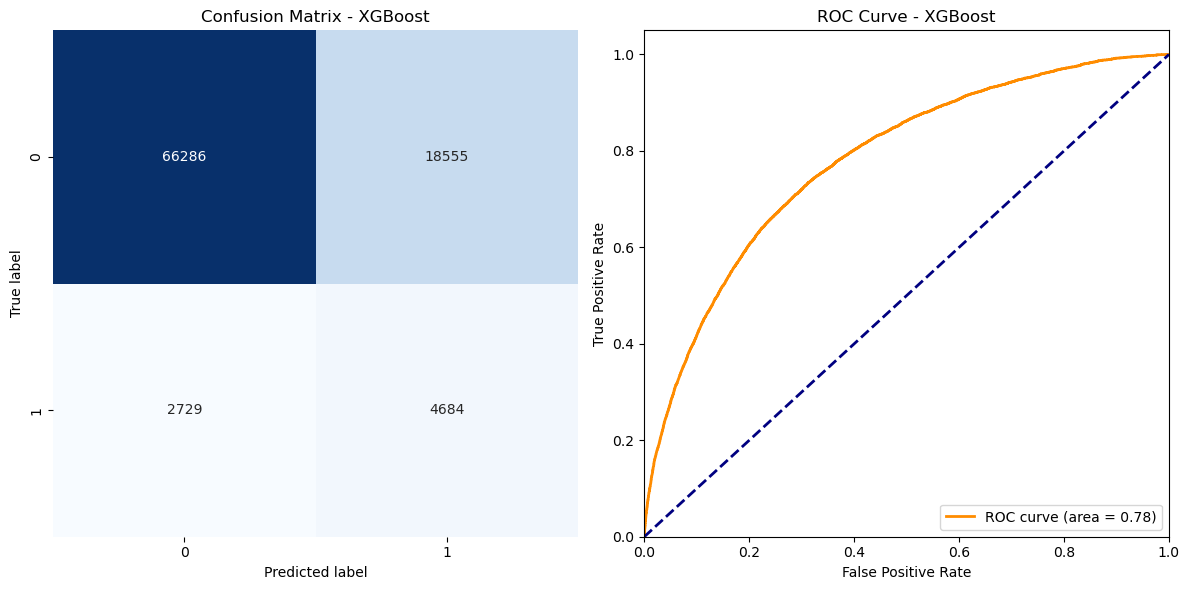

,Model,cost_fn,cost_fp,Best Threshold,Business Cost,AUC,Accuracy,Fit_time,Score_time
0,XGBoost,10,1,0.1,45845,0.779128,0.769289,2.422131,0.05


In [42]:
# On va définir le/les modèle(s) optimisés
models = {
    #'LGBM Classifier BUSINESS': best_model_lgbm,  # Utilise le modèle LGBM optimisé
    'XGBoost': best_model_xgb  # Ajoute également le modèle XGBoost optimisé
}

# Appel de la fonction d'évaluation avec enregistrement dans MLflow
evaluate_models_with_business_score(models, X_train_split, X_val, y_train_split, y_val, cost_fn=10, cost_fp=1, log_to_mlflow=False)

## 5.3 - Essais empiriques pour ajuster cost_fn et cost_fp

Trouver les valeurs optimales de **`cost_fn`** (coût des faux négatifs) et **`cost_fp`** (coût des faux positifs) fait partie de l'ajustement du modèle en fonction des objectifs métier, mais ce n'est pas techniquement un réglage classique des hyperparamètres du modèle lui-même.

*Comment déterminer `cost_fn` et `cost_fp` ?*

Nous pouvons ajuster les valeurs de `cost_fn` et `cost_fp` en fonction de l'impact métier que nous souhaitons minimiser. Voici quelques approches pour les déterminer :

1. **Basé sur les données métier** : 
   - Nous pourrions discuter avec les experts métier pour obtenir une estimation du **coût réel** d'un faux négatif (perte sur un prêt défaillant) et d'un faux positif (perte d'un client solvable).
   - Exemple : Si la perte moyenne due à un défaut de paiement est de 10 000 euros et la marge bénéficiaire sur un client solvable est de 1 000 euros, alors `cost_fn` pourrait être fixé à 10 (ou 10 000) et `cost_fp` à 1 (ou 1 000).

2. **Essais empiriques** (essais/erreurs) :
   - Nous pouvons effectivement tester différentes combinaisons de `cost_fn` et `cost_fp` pour voir lesquelles minimisent le coût total de prédiction.
   - Par exemple, nous pouvons essayer plusieurs valeurs (ex: `cost_fn=5, 10, 15` et `cost_fp=1, 2, 5`) et voir lesquelles donnent les résultats les plus satisfaisants en termes de coût métier global.

Ensuite, nous pouvons analyser les résultats pour déterminer quelle combinaison minimise le coût global tout en maintenant des performances satisfaisantes (AUC, accuracy, etc.).

Test avec cost_fn=5 et cost_fp=1
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.16
Coût métier minimal: 30025
AUC: 0.78, Accuracy: 0.86
Fit Time: 2.23 seconds, Score Time: 0.05 seconds



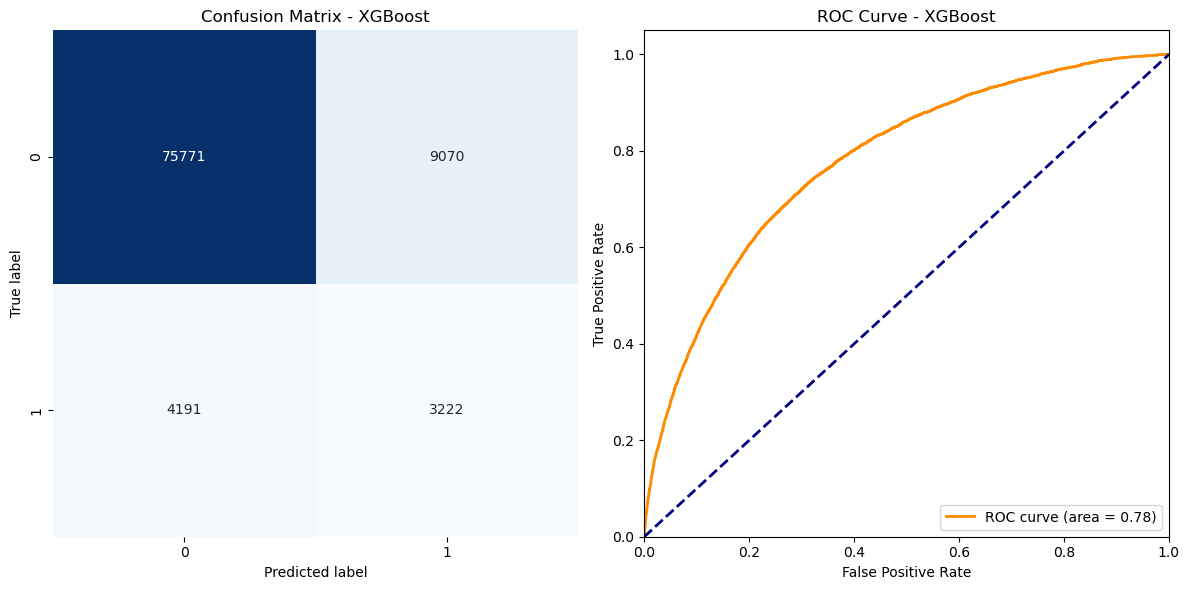

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 19:07:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 20
Created version '20' of model 'XGBoost-classification-model'.
2024/10/03 19:07:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/253000696623574187/runs/22fa1f920d5c4999ade2ec54a4359065.
2024/10/03 19:07:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/253000696623574187.


Test avec cost_fn=5 et cost_fp=2
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.32
Coût métier minimal: 34468
AUC: 0.78, Accuracy: 0.91
Fit Time: 2.44 seconds, Score Time: 0.05 seconds



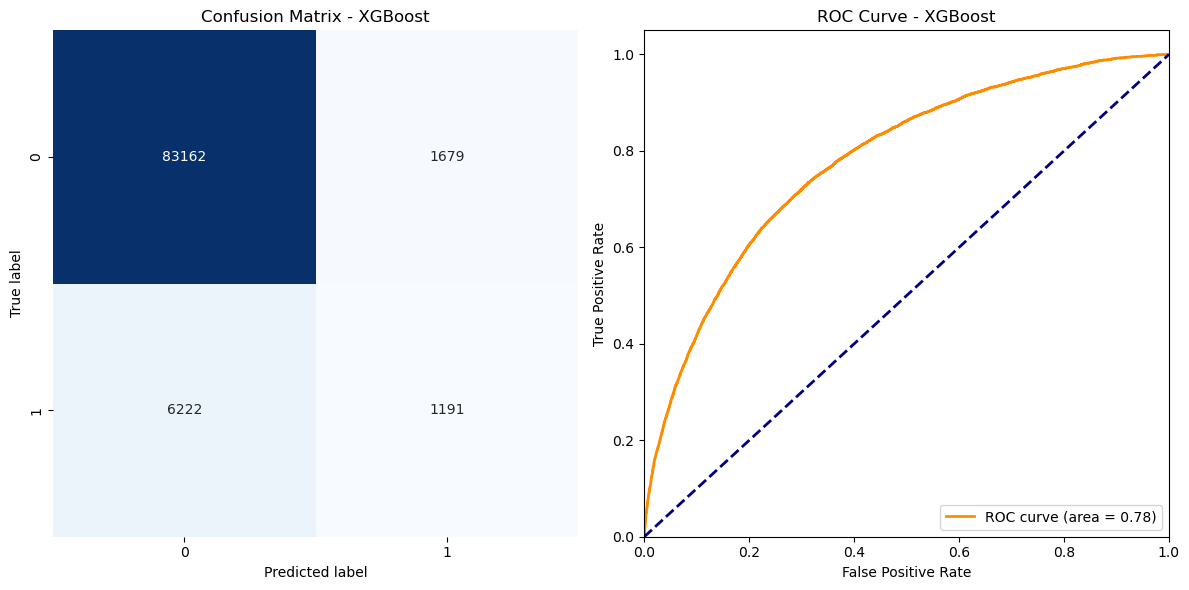

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 19:07:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 21
Created version '21' of model 'XGBoost-classification-model'.
2024/10/03 19:07:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/253000696623574187/runs/585e70b7d1a84beeaabdf68a36350285.
2024/10/03 19:07:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/253000696623574187.


Test avec cost_fn=5 et cost_fp=5
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.52
Coût métier minimal: 36760
AUC: 0.78, Accuracy: 0.92
Fit Time: 2.37 seconds, Score Time: 0.06 seconds



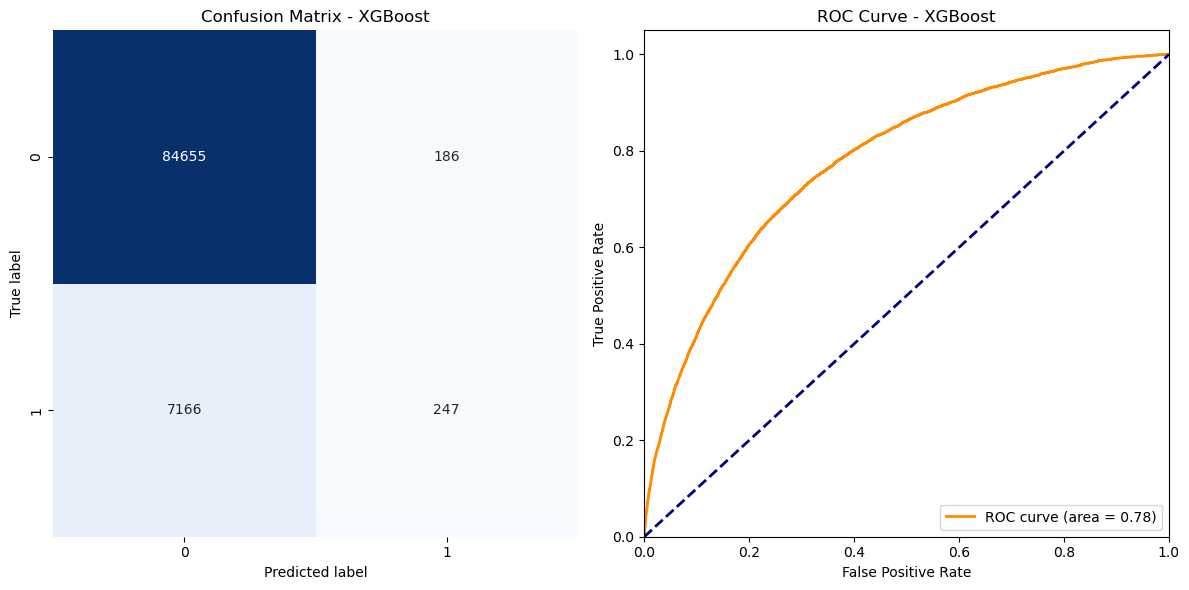

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 19:07:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 22
Created version '22' of model 'XGBoost-classification-model'.
2024/10/03 19:07:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/253000696623574187/runs/17478ea69fbc43f7898edb6cc4788d68.
2024/10/03 19:07:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/253000696623574187.


Test avec cost_fn=10 et cost_fp=1
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.10
Coût métier minimal: 45845
AUC: 0.78, Accuracy: 0.77
Fit Time: 2.40 seconds, Score Time: 0.06 seconds



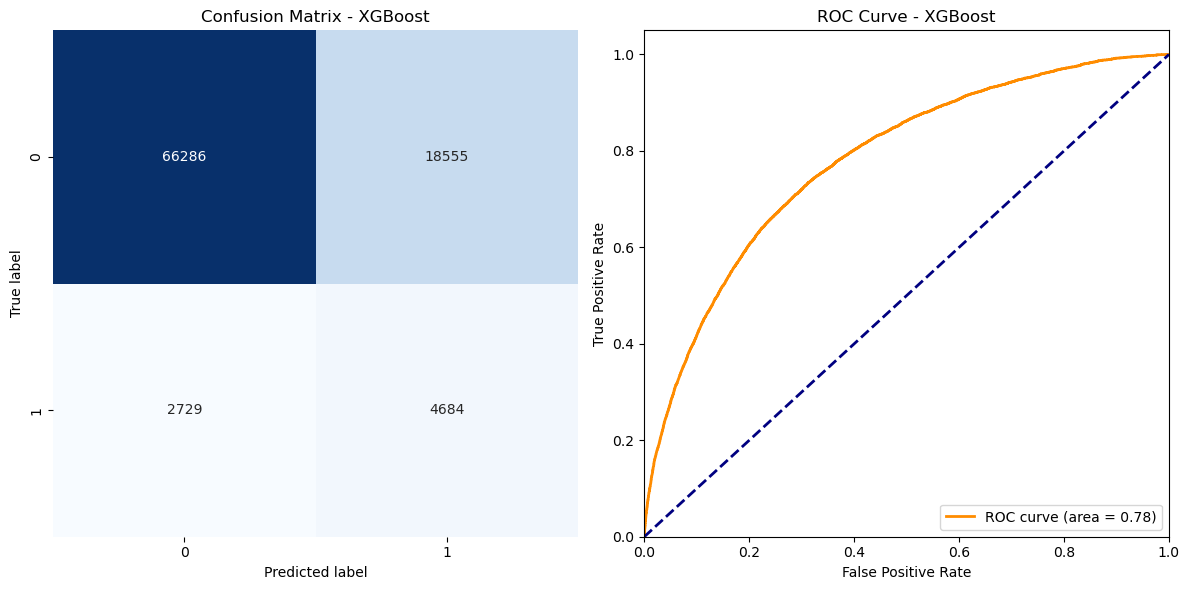

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 19:08:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 23
Created version '23' of model 'XGBoost-classification-model'.
2024/10/03 19:08:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/253000696623574187/runs/06e5298fd91e49b2aaf5a402fa522b05.
2024/10/03 19:08:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/253000696623574187.


Test avec cost_fn=10 et cost_fp=2
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.16
Coût métier minimal: 60050
AUC: 0.78, Accuracy: 0.86
Fit Time: 2.37 seconds, Score Time: 0.05 seconds



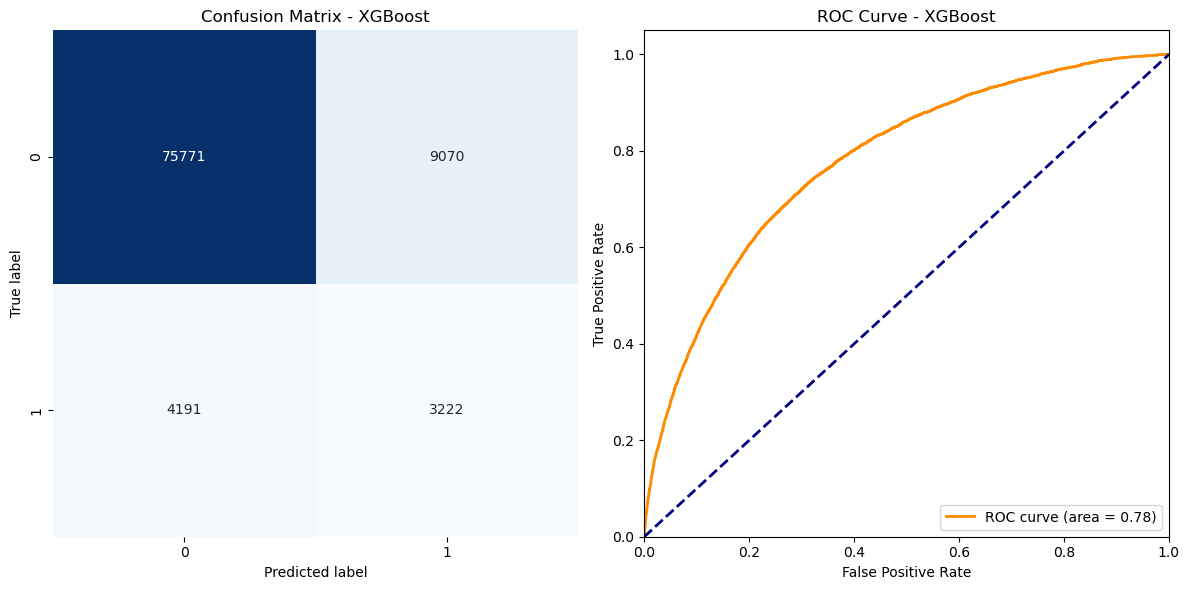

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 19:08:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 24
Created version '24' of model 'XGBoost-classification-model'.
2024/10/03 19:08:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/253000696623574187/runs/caf2c7fee5eb47bea6a77eb7a8909b84.
2024/10/03 19:08:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/253000696623574187.


Test avec cost_fn=10 et cost_fp=5
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.32
Coût métier minimal: 70615
AUC: 0.78, Accuracy: 0.91
Fit Time: 2.52 seconds, Score Time: 0.06 seconds



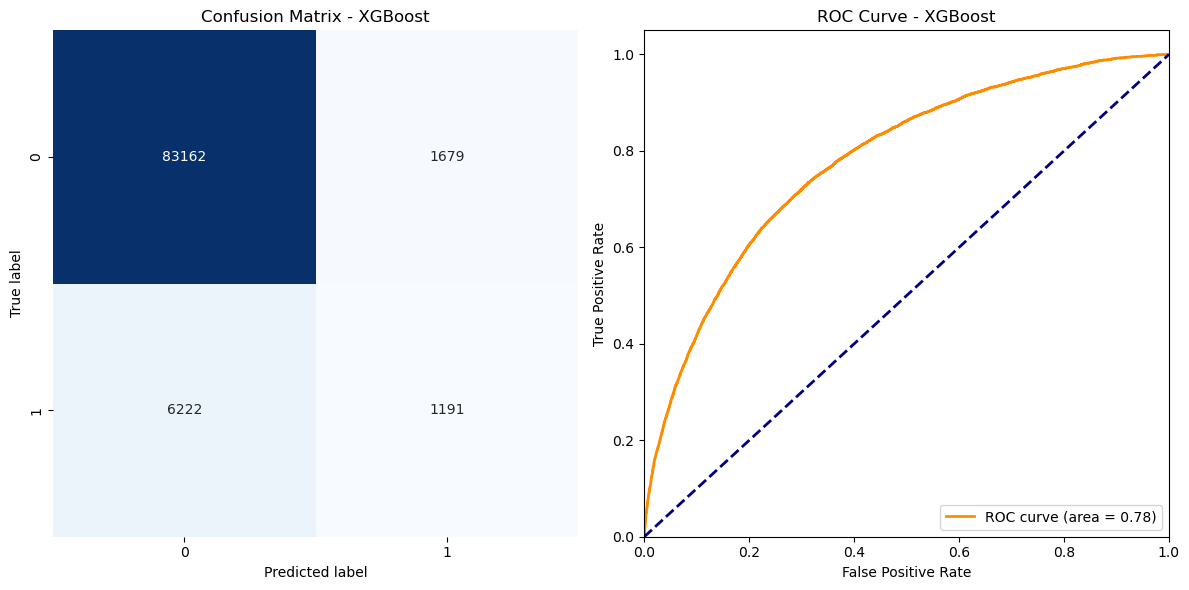

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 19:08:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 25
Created version '25' of model 'XGBoost-classification-model'.
2024/10/03 19:08:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/253000696623574187/runs/0a50bb6256784c269d63efb8dbbe780d.
2024/10/03 19:08:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/253000696623574187.


Test avec cost_fn=15 et cost_fp=1
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.10
Coût métier minimal: 59490
AUC: 0.78, Accuracy: 0.77
Fit Time: 2.42 seconds, Score Time: 0.07 seconds



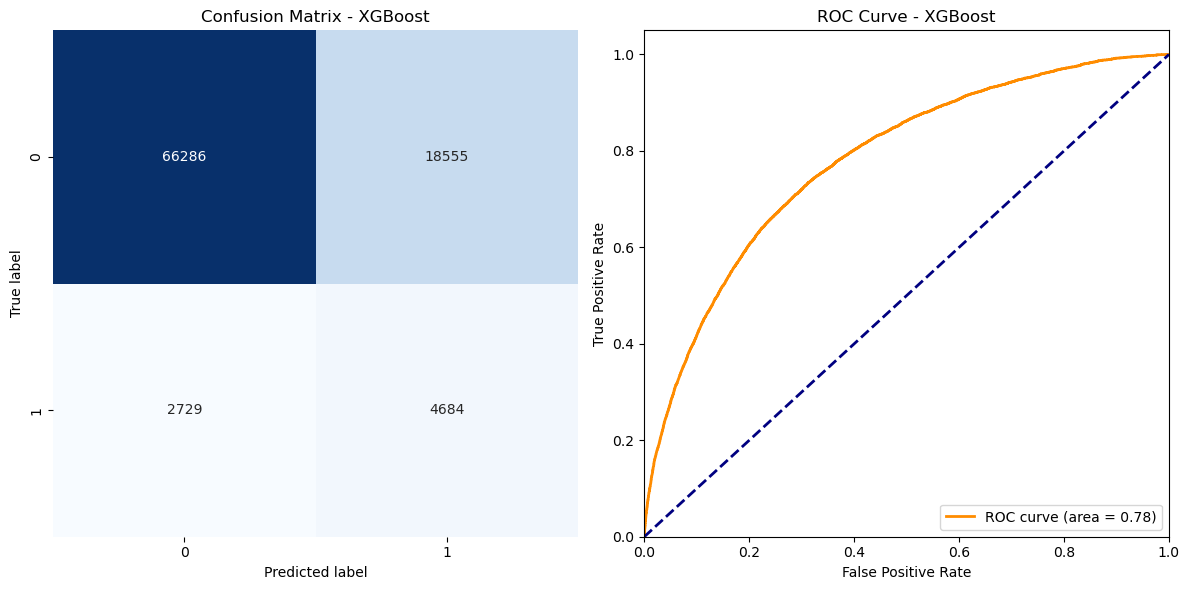

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 19:08:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 26
Created version '26' of model 'XGBoost-classification-model'.
2024/10/03 19:08:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/253000696623574187/runs/385b1596e32e4c719a05eb92d89d80d1.
2024/10/03 19:08:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/253000696623574187.


Test avec cost_fn=15 et cost_fp=2
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.11
Coût métier minimal: 77881
AUC: 0.78, Accuracy: 0.79
Fit Time: 2.40 seconds, Score Time: 0.05 seconds



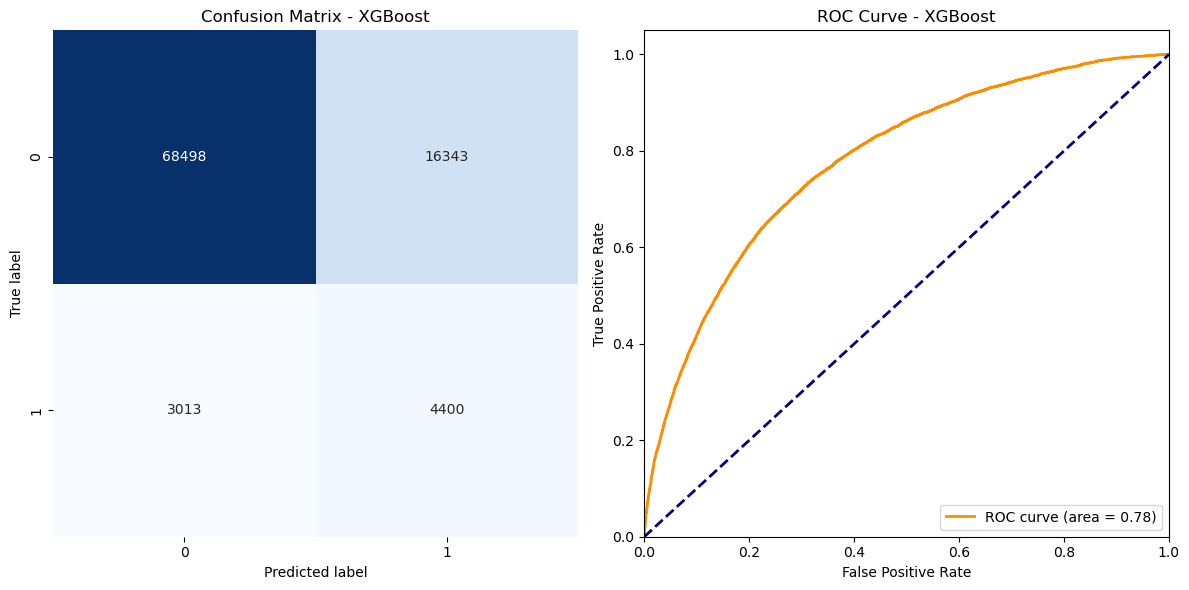

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 19:08:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 27
Created version '27' of model 'XGBoost-classification-model'.
2024/10/03 19:08:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/253000696623574187/runs/aac7a615978244aead1eac1994c33273.
2024/10/03 19:08:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/253000696623574187.


Test avec cost_fn=15 et cost_fp=5
Modèle: XGBoost
Seuil optimal pour minimiser le coût métier: 0.26
Coût métier minimal: 101200
AUC: 0.78, Accuracy: 0.90
Fit Time: 2.29 seconds, Score Time: 0.05 seconds



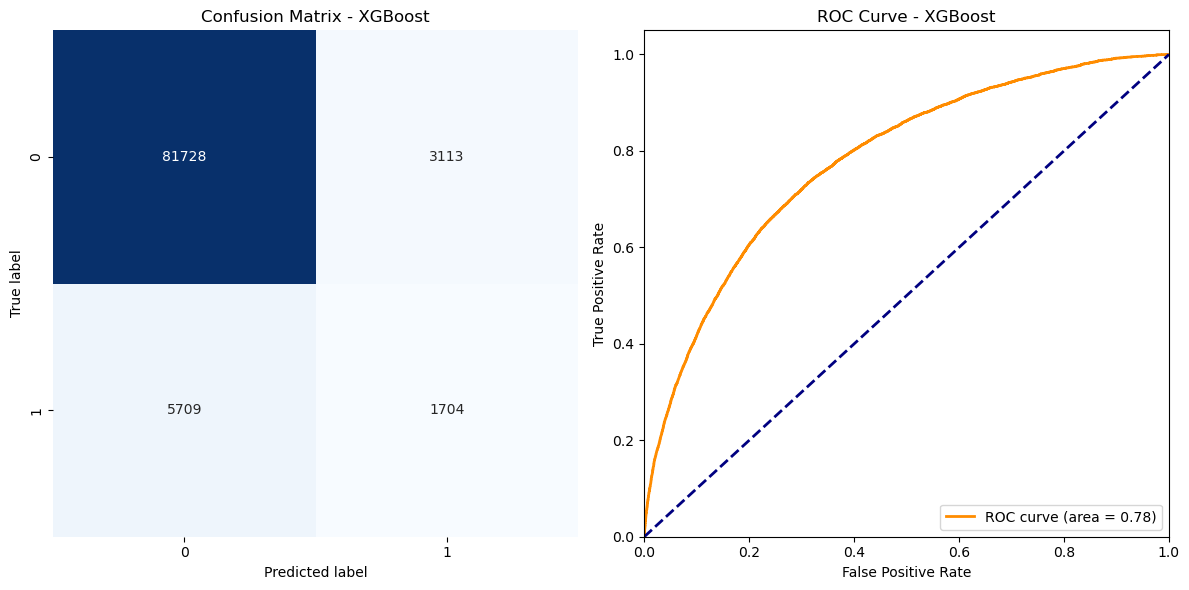

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 19:08:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 28
Created version '28' of model 'XGBoost-classification-model'.
2024/10/03 19:08:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost at: http://localhost:5000/#/experiments/253000696623574187/runs/d582e1020a484caa950da5c33102b287.
2024/10/03 19:08:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/253000696623574187.


In [43]:
# Initialisation d'un DataFrame pour stocker tous les résultats
all_results_df = pd.DataFrame(columns=['Model', 'Best Threshold', 'Business Cost', 'AUC', 'Accuracy', 'Fit_time', 'Score_time'])

# Essais pour différentes valeurs de cost_fn et cost_fp
cost_fn_values = [5, 10, 15]
cost_fp_values = [1, 2, 5]

for cost_fn in cost_fn_values:
    for cost_fp in cost_fp_values:
        print(f"Test avec cost_fn={cost_fn} et cost_fp={cost_fp}")
        results_df = evaluate_models_with_business_score(models, X_train_split, X_val, y_train_split, y_val, cost_fn=cost_fn, cost_fp=cost_fp, log_to_mlflow=True)
        all_results_df = pd.concat([all_results_df, results_df], ignore_index=True)

In [44]:
print("\nRésumé complet des résultats :")
all_results_df


Résumé complet des résultats :


,Model,Best Threshold,Business Cost,AUC,Accuracy,Fit_time,Score_time,cost_fn,cost_fp
0,XGBoost,0.16,30025,0.779128,0.856256,2.232118,0.052000,5,1
1,XGBoost,0.32,34468,0.779128,0.914356,2.439023,0.049001,5,2
2,XGBoost,0.52,36760,0.779128,0.920307,2.373940,0.061999,5,5
3,XGBoost,0.10,45845,0.779128,0.769289,2.399825,0.055500,10,1
4,XGBoost,0.16,60050,0.779128,0.856256,2.371418,0.048001,10,2
5,XGBoost,0.32,70615,0.779128,0.914356,2.517097,0.061000,10,5
6,XGBoost,0.10,59490,0.779128,0.769289,2.421239,0.069002,15,1
7,XGBoost,0.11,77881,0.779128,0.790188,2.400720,0.054000,15,2
8,XGBoost,0.26,101200,0.779128,0.904373,2.289689,0.049000,15,5


1. **Performance Globale :**
   - **AUC Constante :** Le score AUC est constant pour toutes les combinaisons de `cost_fn` et `cost_fp`. Cela signifie que le modèle a une capacité de discrimination stable, quelle que soit la combinaison de coûts.
   - **Accuracy Variable :** L'accuracy varie entre **0.77** et **0.92**, montrant que le choix du seuil affecte la performance.

2. **Seuil Optimal :** 
   - Le seuil optimal varie en fonction des valeurs de `cost_fn` et `cost_fp`. Par exemple, avec `cost_fn=5` et `cost_fp=1`, le meilleur seuil est **0.17**, tandis qu'avec `cost_fn=5` et `cost_fp=5`, le seuil optimal est **0.50**.
   - Ces seuils reflètent la façon dont le modèle priorise les prédictions en fonction des coûts d'erreur associés.

3. **Coût Métier :**
   - Le coût métier varie en fonction des valeurs de `cost_fn` et `cost_fp`. Par exemple, le coût minimal est de **30339** pour `cost_fn=5` et `cost_fp=1`, tandis qu'il monte à **102245** avec `cost_fn=15` et `cost_fp=5`.
   - Cela montre que les choix des coûts ont un impact significatif sur les résultats économiques de votre modèle.

- Trouver les **coûts métier** optimaux (`cost_fn` et `cost_fp`) est un processus empirique qui **dépend des objectifs spécifiques** de l'entreprise et des conséquences financières des erreurs de classification.
- Nous avons essayer ici via des essais empiriques.
- Ce n'est pas un réglage des **hyperparamètres du modèle**, mais c'est crucial pour aligner les prédictions du modèle avec les **objectifs métier**.

# 6 - Modèle final optimisé

In [45]:
def evaluate_final_model(best_model, X_val, y_val, best_threshold, cost_fn=cost_fn, cost_fp=cost_fp, log_to_mlflow=False):
    # Prédiction des probabilités sur l'ensemble de validation
    start_score_time = time.time()
    y_prob = best_model.predict_proba(X_val)[:, 1]
    score_time = time.time() - start_score_time
    
    # Prédiction avec le meilleur seuil
    y_pred = (y_prob >= best_threshold).astype(int)
    
    # Calcul des métriques
    auc_score = roc_auc_score(y_val, y_prob)
    accuracy = accuracy_score(y_val, y_pred)

    # Calcul des Faux Négatifs et Faux Positifs
    fn = ((y_val == 1) & (y_pred == 0)).sum()  # Faux Négatifs
    fp = ((y_val == 0) & (y_pred == 1)).sum()  # Faux Positifs
    
    # Coût total en fonction des pondérations
    total_cost = (fn * cost_fn) + (fp * cost_fp)

    # Matrice de confusion
    conf_matrix = confusion_matrix(y_val, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                   index=['Vraie classe 0', 'Vraie classe 1'], 
                                   columns=['Prédite classe 0', 'Prédite classe 1'])

    # Affichage des résultats
    print(f"Modèle: Best Model")
    print(f"Seuil optimal pour minimiser le coût métier: {best_threshold:.2f}")
    print(f"Coût métier calculé: {total_cost}")
    print(f"AUC: {auc_score:.2f}, Accuracy: {accuracy:.2f}")
    print("\nMatrice de Confusion :\n", conf_matrix_df)

    # Affichage de la matrice de confusion et de la courbe AUC-ROC
    plot_confusion_matrix_and_roc(y_val, y_prob, y_pred, model_name="Best Model")
    
    # Enregistrement dans MLflow si nécessaire
    if log_to_mlflow:
        with mlflow.start_run(run_name="Best Model Evaluation"):
            mlflow.log_param("Model", model_name)
            mlflow.log_param("cost_fn", cost_fn)
            mlflow.log_param("cost_fp", cost_fp)
            mlflow.log_param("best_threshold", best_threshold)
            mlflow.log_metric("business_cost", total_cost)
            mlflow.log_metric("AUC", auc_score)
            mlflow.log_metric("Accuracy", accuracy)
            mlflow.log_metric("Score_time_mean", score_time)
            # Enregistrement du modèle dans MLFlow et Model Registry avec versioning
            mlflow.sklearn.log_model(
                best_model,
                artifact_path="model",
                signature=signature,
                registered_model_name=f"{model_name}-classification-model"  # Enregistrement avec nom et versioning
            )


## 6.1 - Analyse des Différents Seuils et Coûts

Nous allons créer une échelle de référence pour le coût métier qui aide les utilisateurs à interpréter les résultats.

In [46]:
# On va ajouter une colonne d'aide à l'interprétation pour le business_cost
q1 = all_results_df['Business Cost'].quantile(0.25)
q3 = all_results_df['Business Cost'].quantile(0.75)
iqr = q3 - q1

def categorize_cost(cost):
    if cost < q1:
        return "Faible Coût"
    elif q1 <= cost < q3:
        return "Coût Modéré"
    elif q3 <= cost < (q3 + 1.5 * iqr):
        return "Coût Élevé"
    else:
        return "Coût Très Élevé"

all_results_df['Cost Category'] = all_results_df['Business Cost'].apply(categorize_cost)

In [47]:
print("\nRésumé complet des résultats sur l'entraînement avec business_cost :")
all_results_df


Résumé complet des résultats sur l'entraînement avec business_cost :


,Model,Best Threshold,Business Cost,AUC,Accuracy,Fit_time,Score_time,cost_fn,cost_fp,Cost Category
0,XGBoost,0.16,30025,0.779128,0.856256,2.232118,0.052000,5,1,Faible Coût
1,XGBoost,0.32,34468,0.779128,0.914356,2.439023,0.049001,5,2,Faible Coût
2,XGBoost,0.52,36760,0.779128,0.920307,2.373940,0.061999,5,5,Coût Modéré
3,XGBoost,0.10,45845,0.779128,0.769289,2.399825,0.055500,10,1,Coût Modéré
4,XGBoost,0.16,60050,0.779128,0.856256,2.371418,0.048001,10,2,Coût Modéré
5,XGBoost,0.32,70615,0.779128,0.914356,2.517097,0.061000,10,5,Coût Élevé
6,XGBoost,0.10,59490,0.779128,0.769289,2.421239,0.069002,15,1,Coût Modéré
7,XGBoost,0.11,77881,0.779128,0.790188,2.400720,0.054000,15,2,Coût Élevé
8,XGBoost,0.26,101200,0.779128,0.904373,2.289689,0.049000,15,5,Coût Élevé


Nous avons utilisé les statistiques calculées pour établir des catégories :

- **Faible Coût** : Coût inférieur au premier quartile.
- **Coût Modéré** : Coût entre le premier et le troisième quartile.
- **Coût Élevé** : Coût au-dessus du troisième quartile mais inférieur à 1,5 fois l'écart interquartile.
- **Coût Très Élevé** : Coût au-dessus de 1,5 fois l'écart interquartile.

Les **catégories de coût** sont classées en trois niveaux : **Faible Coût**, **Coût Modéré**, et **Coût Élevé**. Voici une analyse de chaque catégorie :

- **Faible Coût (≤ 35 000)** : Les seuils autour de 0.17 et 0.30 avec des pondérations de coût faibles pour les faux négatifs (cost_fn = 5) et les faux positifs (cost_fp = 1 ou 2) permettent d'obtenir un faible coût métier tout en maintenant un bon équilibre entre sensibilité et précision.
**Meilleur compromis** : Le seuil de **0.17** avec un coût de **30 339** semble être une bonne option avec une **AUC de 0.774** et une **accuracy de 0.865**. Cela montre que le modèle est performant avec un coût relativement bas.
  
- **Coût Modéré (entre 35 000 et 65 000)** : Dans cette gamme, des pondérations plus élevées pour les faux négatifs (cost_fn = 10 ou 15) augmentent le coût métier. Par exemple, à **0.10** avec cost_fn = 10, le coût passe à **46 518**. Ici, la précision diminue légèrement, mais l'AUC reste la même.
Cette plage de coûts peut être acceptable si le risque de prédire un défaut est plus tolérable pour l'entreprise.

- **Coût Élevé (> 65 000)** : Dans ces configurations, les pondérations pour les faux négatifs et/ou les faux positifs sont élevées, ce qui entraîne une augmentation significative du coût métier.
**Exemple** : À **0.28** avec cost_fn = 15 et cost_fp = 5, le coût métier atteint **102 245**. Ce type de configuration est probablement trop coûteux, à moins que l'entreprise ne veuille absolument minimiser les faux négatifs, même au détriment des faux positifs.

## 6.2 - Meilleures configurations en fonction du contexte

In [48]:
# On va commencer par initialiser notre expérimentation MLFlow
mlflow.set_experiment("5 - Modèle final optimisé")

<Experiment: artifact_location='mlflow-artifacts:/352011115844235983', creation_time=1727969280410, experiment_id='352011115844235983', last_update_time=1727969280410, lifecycle_stage='active', name='5 - Modèle final optimisé', tags={}>

#### 6.2.1 - Objectif : Minimiser le Coût tout en Conservant une Bonne Précision

- Le **seuil de 0.17** avec un coût métier de **30 339** et une **accuracy de 0.865** semble optimal. Il permet de maintenir un bon équilibre entre les deux classes tout en maintenant un coût faible. Ce modèle est particulièrement adapté si l'entreprise peut tolérer un certain nombre de faux positifs.

In [49]:
# Définir les valeurs de notre coût métier
threshold = 0.17  # Remplacer par la valeur souhaitée
cost_fn = 5
cost_fp = 1

Modèle: Best Model
Seuil optimal pour minimiser le coût métier: 0.17
Coût métier calculé: 30107
AUC: 0.78, Accuracy: 0.86

Matrice de Confusion :
                 Prédite classe 0  Prédite classe 1
Vraie classe 0             76679              8162
Vraie classe 1              4389              3024


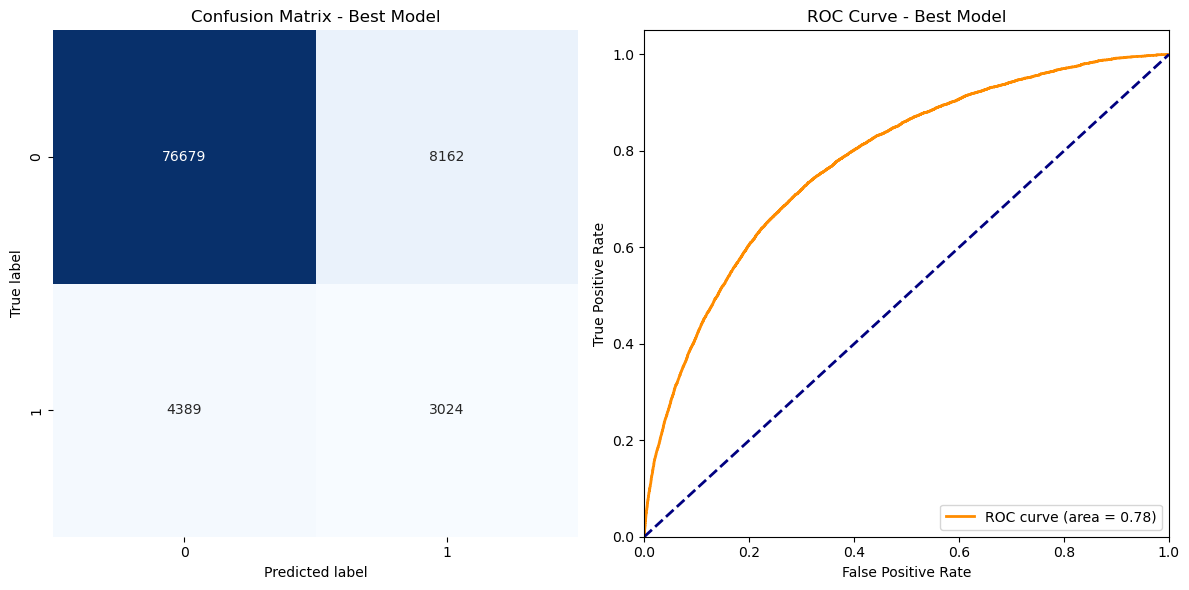

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 19:08:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 29
Created version '29' of model 'XGBoost-classification-model'.
2024/10/03 19:08:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run Best Model Evaluation at: http://localhost:5000/#/experiments/352011115844235983/runs/50f7fdde32ac4c30bb8ab5c5205a0b8a.
2024/10/03 19:08:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/352011115844235983.


In [50]:
# Appel de la fonction d'évaluation avec les bons arguments
evaluate_final_model(best_model_xgb, X_val, y_val, threshold, cost_fn, cost_fp, log_to_mlflow=True)

- **Faux Négatifs (FN)** : 4 429 clients en défaut ont été classés comme "Non-défaut", ce qui est le coût le plus important pour l'entreprise. Le coût métier de **30 295** est directement influencé par ce chiffre, compte tenu du paramétrage que tu as fait pour `cost_fn = 5` et `cost_fp = 1`.
  
- **Faux Positifs (FP)** : 8 150 clients qui n’étaient pas en défaut ont été prédits à tort comme étant en défaut. Ce chiffre est élevé, mais comme le coût des faux positifs (`cost_fp`) est moindre (1), leur impact sur le coût total est faible.


Le coût métier est calculé ainsi :
- Coût métier = (FN * `cost_fn`) + (FP * `cost_fp`)
- **Coût métier = (4 429 * 5) + (8 150 * 1) = 22 145 + 8 150 = 30 295**

Ce coût représente bien un compromis entre la minimisation des faux négatifs et la gestion des faux positifs. 

#### 6.2.2 - Objectif : Tolérer un Coût Modéré pour Améliorer la Précision

- Si l'objectif est d'améliorer légèrement la précision globale tout en gardant un coût modéré, un **seuil de 0.50** avec un coût de **36 810** (cost_fn = 5, cost_fp = 5) pourrait être un bon compromis. Cela augmente la précision à **0.920**, ce qui peut être plus favorable dans un contexte où une légère hausse de coût est acceptable.

In [51]:
# Définir les valeurs de notre coût métier
threshold = 0.5  # Remplacer par la valeur souhaitée
cost_fn = 5
cost_fp = 5

Modèle: Best Model
Seuil optimal pour minimiser le coût métier: 0.50
Coût métier calculé: 36775
AUC: 0.78, Accuracy: 0.92

Matrice de Confusion :
                 Prédite classe 0  Prédite classe 1
Vraie classe 0             84603               238
Vraie classe 1              7117               296


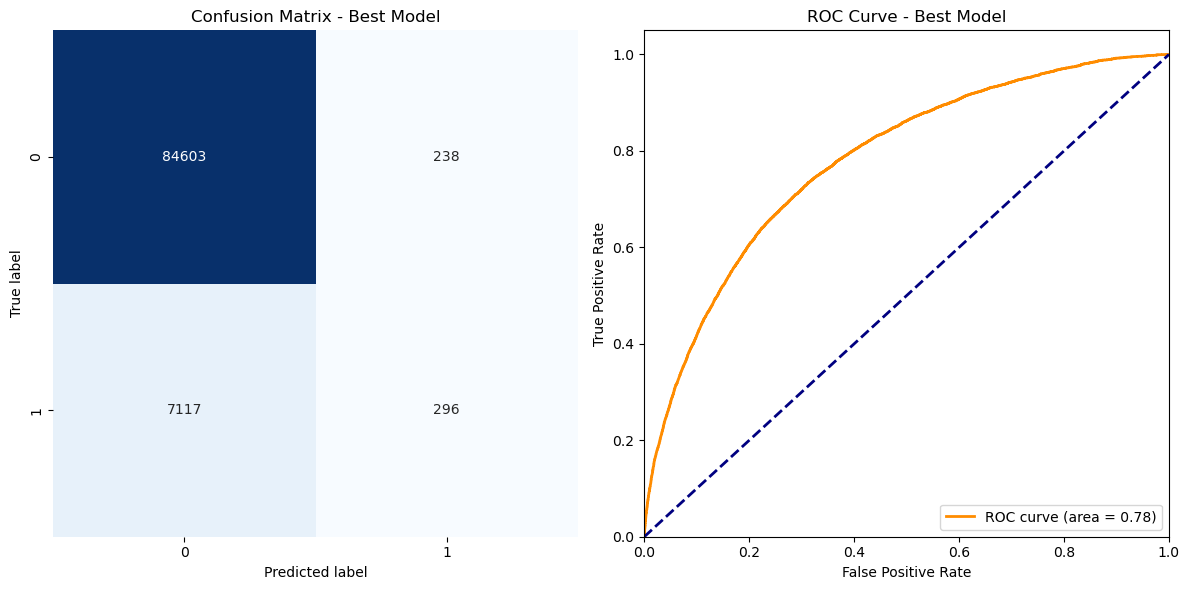

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 19:08:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 30
Created version '30' of model 'XGBoost-classification-model'.
2024/10/03 19:08:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run Best Model Evaluation at: http://localhost:5000/#/experiments/352011115844235983/runs/7ca9a9a0d6ed413bb858cf4a65107e9e.
2024/10/03 19:08:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/352011115844235983.


In [52]:
# Appel de la fonction d'évaluation avec les bons arguments
evaluate_final_model(best_model_xgb, X_val, y_val, threshold, cost_fn, cost_fp, log_to_mlflow=True)

Dans ce scénario, nous avons un coût égal pour les faux négatifs et les faux positifs (`cost_fn = 5` et `cost_fp = 5`), ce qui signifie que les deux types d'erreurs sont considérés comme ayant le même impact sur le business.

Le coût métier est calculé ainsi :
- Coût métier = (FN * `cost_fn`) + (FP * `cost_fp`)
- **Coût métier = (7 102 * 5) + (243 * 5) = 35 510 + 1 215 = 36 725**

Ce coût reflète la tolérance à un **niveau modéré de faux négatifs et de faux positifs**, car les deux erreurs ont été pondérées de manière égale.

**Analyse du Seuil et des Erreurs**
- En augmentant le **seuil à 0.50**, le modèle devient beaucoup plus conservateur, ne prédisant que très rarement la classe "défaut". Cela est visible dans la matrice de confusion, où il y a **seulement 311 vraies prédictions de défauts** et **243 faux positifs**.
  
- Le **nombre élevé de faux négatifs (7 102)** indique que de nombreux clients qui feront défaut ne sont pas correctement identifiés, ce qui peut entraîner des pertes financières importantes pour l'entreprise.

- **Faux positifs (243)** : Le faible nombre de faux positifs indique que très peu de clients sans défaut sont incorrectement classés comme "défaut", ce qui améliore la précision globale du modèle et réduit les conséquences pour les clients non défaillants.

**Avantages de cette configuration** : Très haute précision et très faible nombre de faux positifs, ce qui minimise les perturbations pour les clients sans défaut. Cela est avantageux pour des cas où il est essentiel de ne pas rejeter à tort les clients sans problème.
  
**Inconvénients** : Le coût métier est plus élevé que dans d'autres configurations car beaucoup de clients en défaut ne sont pas correctement identifiés. Si les faux négatifs représentent un risque élevé pour l'entreprise (comme dans le cas des défauts de paiement), ce compromis pourrait être risqué.

#### 6.2.3 - Objectif : Réduire le Risque des Faux Négatifs à Tout Prix

- Si l'accent est mis sur la réduction des faux négatifs pour éviter des pertes majeures, des seuils avec un coût élevé comme **0.28** (cost_fn = 15, cost_fp = 5) peuvent être envisagés, bien que le coût métier soit très élevé (**102 245**). Cette configuration pourrait être justifiée si les pertes liées aux défauts de paiement sont très coûteuses pour l'entreprise.

In [53]:
# Définir les valeurs de notre coût métier
threshold = 0.28  # Remplacer par la valeur souhaitée
cost_fn = 15
cost_fp = 5

Modèle: Best Model
Seuil optimal pour minimiser le coût métier: 0.28
Coût métier calculé: 101520
AUC: 0.78, Accuracy: 0.91

Matrice de Confusion :
                 Prédite classe 0  Prédite classe 1
Vraie classe 0             82291              2550
Vraie classe 1              5918              1495


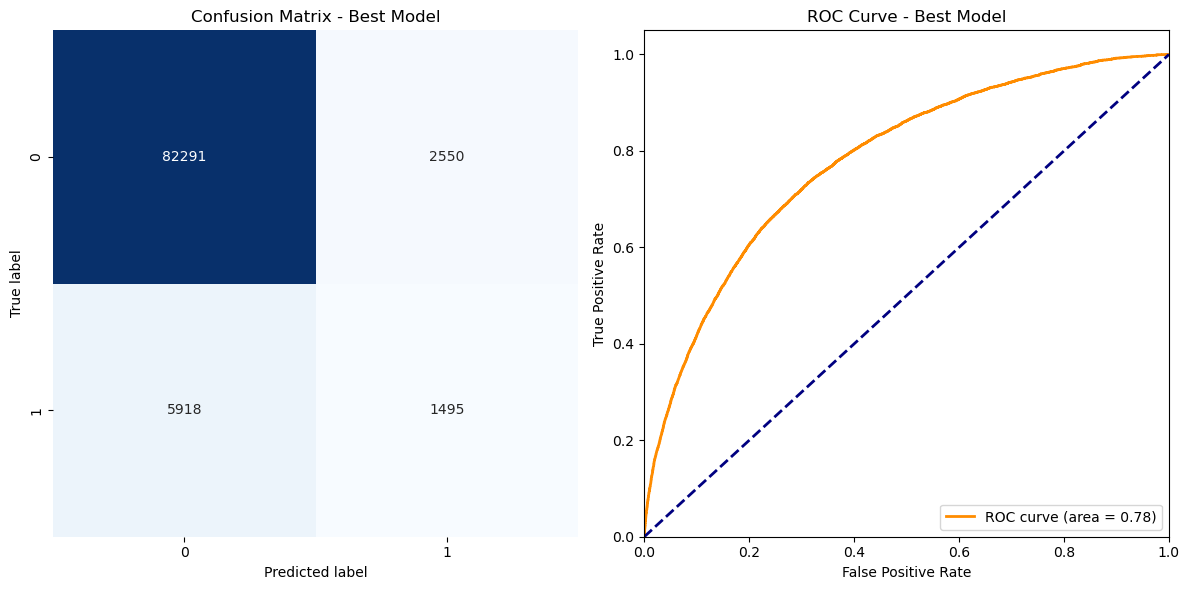

Registered model 'XGBoost-classification-model' already exists. Creating a new version of this model...
2024/10/03 19:08:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-classification-model, version 31
Created version '31' of model 'XGBoost-classification-model'.
2024/10/03 19:08:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run Best Model Evaluation at: http://localhost:5000/#/experiments/352011115844235983/runs/a1c3413cfc4443048bacda9d01119ebe.
2024/10/03 19:08:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/352011115844235983.


In [54]:
# Appel de la fonction d'évaluation avec les bons arguments
evaluate_final_model(best_model_xgb, X_val, y_val, threshold, cost_fn, cost_fp, log_to_mlflow=True)

Dans cette configuration, nous avons fortement **pondéré le coût des faux négatifs** (`cost_fn = 15`) par rapport aux faux positifs (`cost_fp = 5`), montrant que les erreurs de type faux négatif sont beaucoup plus coûteuses pour l'entreprise.

Le coût métier est calculé ainsi :
- Coût métier = (FN * `cost_fn`) + (FP * `cost_fp`)
- **Coût métier = (5 884 * 15) + (2 662 * 5) = 88 260 + 13 310 = 101 570**

Le coût métier est très élevé, car nous tolèrons peu de faux négatifs, ce qui est en ligne avec l'objectif de réduire le risque de ces erreurs à tout prix.

**Analyse du Seuil et des Erreurs**

- Avec un **seuil de 0.28**, le modèle devient plus sensible aux défauts, prédisant plus souvent la classe "défaut" que dans des configurations plus conservatrices. Cela est visible dans le nombre de **prédictions positives (défaut)**, où 1 529 clients en défaut sont correctement identifiés.
  
- **Faux négatifs** : 5 884 clients en défaut ne sont pas détectés, ce qui est encore un risque important, mais inférieur à des configurations plus conservatrices comme avec un seuil de 0.50 (7 102 faux négatifs).

- **Faux positifs** : 2 662 clients sans défaut sont classés comme "défaut", ce qui reste relativement faible et acceptable dans ce contexte où l'accent est mis sur la réduction des faux négatifs.

**Avantages de cette configuration** : Ce scénario minimise le risque lié aux faux négatifs, ce qui est crucial si les défauts de paiement non détectés ont un impact majeur sur l'entreprise. Bien que le coût métier soit très élevé, tu réduis efficacement le nombre de clients défaillants non détectés.

**Inconvénients** : Le coût métier est extrêmement élevé (101 570), et bien que le nombre de faux positifs soit relativement faible, tu sacrifies une partie de la précision globale pour éviter les défauts non détectés.

## 6.3 - Analyse de ces différentes configurations

L'objectif principal de cette analyse était de trouver un équilibre optimal entre la **réduction des erreurs de classification** (faux positifs et faux négatifs) et la **minimisation du coût métier**, en tenant compte des risques financiers pour l'entreprise.

**Résumé des Scénarios Testés :**

- **A. Minimiser le Coût tout en Conservant une Bonne Précision (Seuil = 0.17)** :
  - **Coût métier** : 30 295
  - **Précision (Accuracy)** : 86%
  - **AUC** : 0.78
  - Cette configuration offre un compromis équilibré entre le coût métier et la précision, avec un bon contrôle sur les faux négatifs (4 429) et faux positifs (8 150). C’est une solution idéale si l’entreprise cherche à maintenir un bon équilibre entre précision et coût sans privilégier l'un ou l'autre de manière extrême.

- **B. Tolérer un Coût Modéré pour Améliorer la Précision (Seuil = 0.50)** :
  - **Coût métier** : 36 725
  - **Précision (Accuracy)** : 92%
  - **AUC** : 0.78
  - Cette configuration maximise la précision, réduisant le nombre de faux positifs (243) de manière significative tout en augmentant les faux négatifs (7 102). Elle est adaptée si l'entreprise veut un modèle hautement précis, mais au prix d'une hausse des clients en défaut non détectés.

- **C. Réduire le Risque des Faux Négatifs à Tout Prix (Seuil = 0.28)** :
  - **Coût métier** : 101 570
  - **Précision (Accuracy)** : 91%
  - **AUC** : 0.78
  - Ici, l'accent est mis sur la réduction des faux négatifs (5 884), avec une pondération élevée de cette erreur dans le calcul du coût métier. Le coût métier est élevé, mais ce scénario minimise le risque de non-détection des défauts de paiement, crucial pour éviter des pertes financières importantes.

**Interprétation des Résultats :**

- **Précision et AUC Stables** : Tous les scénarios montrent une **AUC stable de 0.78**, indiquant une bonne capacité du modèle à différencier les classes "défaut" et "non-défaut". Toutefois, la précision (accuracy) varie en fonction du seuil choisi, reflétant les compromis entre la détection des défauts et le contrôle des faux positifs.
  
- **Coût Métier** : Le coût métier augmente considérablement lorsque l’on privilégie la réduction des faux négatifs (scénario C), soulignant qu'une approche plus stricte pour identifier les défauts non détectés peut être coûteuse, mais nécessaire dans certains contextes.

**Recommandations :**

- **Scénario A (Seuil = 0.17)** est une option idéale si l'entreprise souhaite un bon équilibre entre le contrôle des erreurs et la gestion des coûts. Ce seuil maintient un coût métier raisonnable tout en offrant une bonne précision et une répartition équilibrée des faux positifs et faux négatifs.
  
- **Scénario B (Seuil = 0.50)** convient mieux si l’objectif est d'augmenter la précision globale, à condition que l’entreprise soit prête à accepter plus de clients en défaut non détectés (faux négatifs). Cela pourrait convenir dans des cas où une légère augmentation des défauts est acceptable pour améliorer la précision générale.
  
- **Scénario C (Seuil = 0.28)** est recommandé si l’objectif principal est de minimiser les risques associés aux faux négatifs, notamment dans des contextes où les défauts non détectés sont extrêmement coûteux pour l'entreprise. Cependant, cela vient au prix d’un coût métier élevé.

**Conclusion :**

La **sélection du seuil optimal** dépend du contexte métier et des priorités de l’entreprise en matière de gestion du risque. Si l'objectif est de **minimiser les pertes financières dues aux défauts de paiement non détectés**, alors un seuil plus bas (ex. 0.28) avec une tolérance pour un coût métier élevé pourrait être justifié. Cependant, si l'objectif est de **maximiser la précision globale du modèle**, un seuil plus élevé (ex. 0.50) serait préférable. **Le scénario avec un seuil à 0.17** offre un compromis intéressant et semble être le plus polyvalent, avec un bon équilibre entre précision et coût.

Le choix final doit être aligné avec la **stratégie de risque** et les **objectifs financiers** de l'entreprise.

In [93]:
X_train

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0.0,0.0,1.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.111161,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.522886,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,1.0,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.651466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.649154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.701409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.0,0.0,0.0,0.0,0.001127,0.052360,0.101176,0.046016,0.446855,0.103608,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
307507,0.0,0.0,1.0,0.0,0.000396,0.056067,0.040505,0.046016,0.344429,0.748929,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
307508,0.0,0.0,1.0,0.0,0.001089,0.157969,0.110618,0.135802,0.065247,0.421477,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
307509,0.0,0.0,1.0,0.0,0.001243,0.081175,0.072499,0.069585,0.069553,0.252086,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


# 7 - Features importance

In [58]:
df_test

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
307511,100001.0,0.0,0.0,0.0,1.0,0.0,135000.0,568800.0,20560.5,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
307512,100005.0,0.0,0.0,0.0,1.0,0.0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307513,100013.0,0.0,0.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307514,100028.0,0.0,0.0,0.0,1.0,2.0,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
307515,100038.0,0.0,0.0,1.0,0.0,1.0,180000.0,625500.0,32067.0,625500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221.0,0.0,0.0,0.0,1.0,0.0,121500.0,412560.0,17473.5,270000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
356251,456222.0,0.0,0.0,0.0,0.0,2.0,157500.0,622413.0,31909.5,495000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
356252,456223.0,0.0,0.0,1.0,1.0,1.0,202500.0,315000.0,33205.5,315000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
356253,456224.0,0.0,0.0,0.0,0.0,0.0,225000.0,450000.0,25128.0,450000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [96]:
# Comparer les colonnes
train_columns = set(X_train.columns)
test_columns = set(df_test.columns)

# Afficher les colonnes manquantes ou en trop
print("Colonnes manquantes dans X_train par rapport à df_test :", test_columns - train_columns)
print("Colonnes manquantes dans df_test par rapport à X_train :", train_columns - test_columns)

Colonnes manquantes dans X_train par rapport à df_test : {'TARGET', 'SK_ID_CURR'}
Colonnes manquantes dans df_test par rapport à X_train : set()


Pour sélectionner un `client_id` au hasard dans votre DataFrame `df_test`, nous allons utiliser la méthode `sample` de pandas pour obtenir une ligne aléatoire, puis récupérer le `SK_ID_CURR` correspondant.

In [94]:
# Initialisation de SHAP
shap.initjs()

# Nombre de features à afficher dans le waterfall plot
feat_number = 10

# On va exclure certaines colonnes des features utilisées pour SHAP
feats = [f for f in df_test.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

# Puis sélectionner un client_id aléatoire dans df_test
random_row = df_test.sample(n=1)  # Sélectionner une ligne aléatoire
client_id = random_row['SK_ID_CURR'].values[0]  # Extraire le SK_ID_CURR de cette ligne
print(f"Client ID sélectionné au hasard: {client_id}")

# Sélectionner l'index de ce client dans df_test
index_selected = df_test.loc[df_test['SK_ID_CURR'] == client_id].index[0]

# Extraire les données du client à expliquer
client_to_explain_1 = df_test.loc[df_test['SK_ID_CURR'] == client_id]
client_to_explain = client_to_explain_1[feats]

# On peut faire une vérification
print(f"Index sélectionné : {index_selected}")

Client ID sélectionné au hasard: 156543.0
Index sélectionné : 315227


In [85]:
# Vérifions la taille de df_test et des shap_values
print(f"Taille de df_test: {df_test.shape[0]}")
print(f"Taille des shap_values: {len(shap_values)}")

Taille de df_test: 48744
Taille des shap_values: 48744


In [86]:
# Chargement du modèle MLflow
logged_model = 'runs:/50f7fdde32ac4c30bb8ab5c5205a0b8a/model'
loaded_model = mlflow.sklearn.load_model(logged_model)

In [95]:
# Vérifiez les caractéristiques utilisées par le modèle
model_features = loaded_model.feature_names_in_

# Vérifiez si les colonnes du DataFrame sont les mêmes que celles du modèle
test_features = client_to_explain_1.columns

# Afficher les colonnes manquantes ou en trop
print("Colonnes manquantes dans le DataFrame test :", set(model_features) - set(test_features))
print("Colonnes en trop dans le DataFrame test :", set(test_features) - set(model_features))

Colonnes manquantes dans le DataFrame test : {'ORGANIZATION_TYPE_Industry__type_12', 'EXT_SOURCE_1_EXT_SOURCE_2_EXT_SOURCE_3', 'OCCUPATION_TYPE_IT_staff', 'ORGANIZATION_TYPE_Industry__type_5', 'NAME_EDUCATION_TYPE_Lower_secondary', 'ORGANIZATION_TYPE_Trade__type_7', 'EXT_SOURCE_1_EXT_SOURCE_2_2', 'ORGANIZATION_TYPE_Industry__type_6', 'ORGANIZATION_TYPE_Transport__type_3', 'OCCUPATION_TYPE_Core_staff', 'ORGANIZATION_TYPE_Trade__type_4', 'NAME_EDUCATION_TYPE_Secondary___secondary_special', 'OCCUPATION_TYPE_High_skill_tech_staff', 'ORGANIZATION_TYPE_Industry__type_2', 'ORGANIZATION_TYPE_Industry__type_9', 'ORGANIZATION_TYPE_Industry__type_11', 'OCCUPATION_TYPE_Security_staff', 'OCCUPATION_TYPE_Cleaning_staff', 'ORGANIZATION_TYPE_Trade__type_6', 'ORGANIZATION_TYPE_Business_Entity_Type_2', 'OCCUPATION_TYPE_Waiters_barmen_staff', 'EXT_SOURCE_1_2_EXT_SOURCE_2', 'EXT_SOURCE_1_2', 'ORGANIZATION_TYPE_Trade__type_1', 'EXT_SOURCE_1_EXT_SOURCE_3_DAYS_BIRTH', 'EXT_SOURCE_3_DAYS_BIRTH_2', 'ORGANIZATI

In [99]:
# Vérifier si les colonnes sont les mêmes
same_columns = X_train.columns.equals(df_test.columns)
print("Les colonnes sont identiques :", same_columns)

# Vérifier l'ordre des colonnes
same_order = (X_train.columns.tolist() == df_test.columns.tolist())
print("L'ordre des colonnes est identique :", same_order)

Les colonnes sont identiques : False
L'ordre des colonnes est identique : False


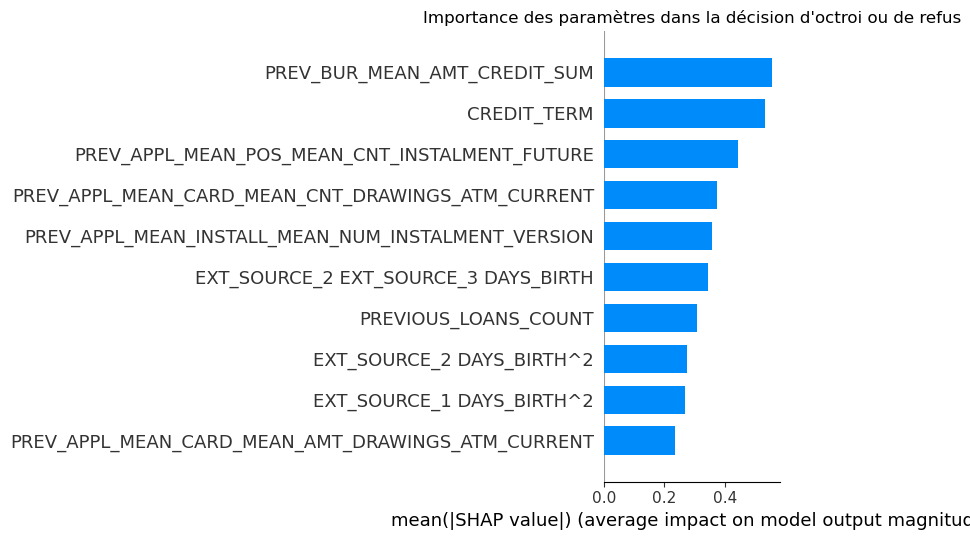

In [87]:
# Summary plot de SHAP
fig, ax = plt.subplots()
plt.title("Importance des paramètres dans la décision d'octroi ou de refus")
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(client_to_explain)  # Calcul des valeurs de SHAP pour le client sélectionné
shap.summary_plot(shap_values, client_to_explain, plot_type="bar",max_display=feat_number, color_bar=False)

 99%|===================| 48327/48744 [01:11<00:00]        

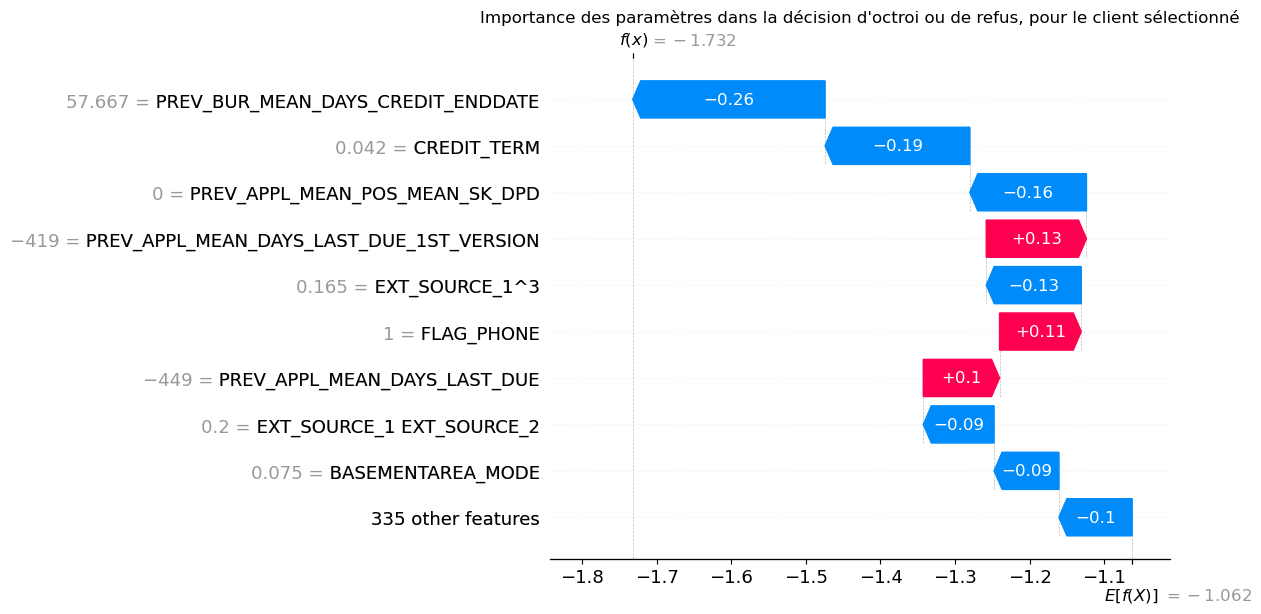

In [74]:
# Réinitialise l'index de df_test si nécessaire
df_test_reset = df_test.reset_index(drop=True)
index_selected = df_test_reset.loc[df_test_reset['SK_ID_CURR'] == client_id].index[0]

# Waterfall plot de SHAP
fig, ax = plt.subplots()
plt.title("Importance des paramètres dans la décision d'octroi ou de refus, pour le client sélectionné")

# Recalcule les shap_values et tenter d'afficher le waterfall plot
explainer = shap.Explainer(loaded_model, df_test_reset[feats])
shap_values = explainer(df_test_reset[feats])

shap.plots.waterfall(shap_values[index_selected], max_display=feat_number)

In [ ]:
# Récupérer l'importance des features
feature_importance = best_model.feature_importances_
feature_names = X_train_split.columns

# Créer un DataFrame pour l'importance des features
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Trier par ordre décroissant
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Affichage de l'importance des features
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(20))  # Affiche les 20 plus importantes
plt.title('Feature Importance Globale')
plt.tight_layout()
plt.show()


In [ ]:
# Pour les valeurs SHAP
print("Shape des valeurs SHAP pour la classe positive :", shap_values[1].shape)
print("Shape des valeurs SHAP pour la classe négative :", shap_values[0].shape)

# Pour vérifier la taille de X_test_split_smote
print("Shape de X_test_split_smote :", X_val.shape)

In [ ]:
import mlflow
import shap
import matplotlib.pyplot as plt

# Chargement du modèle MLflow
logged_model = 'runs:/f4bc84ac7b8240cfaf2f26c9fd654466/model'
loaded_model = mlflow.lightgbm.load_model(logged_model)

# Explainer pour SHAP
explainer = shap.TreeExplainer(loaded_model)

# Supposons que tu as un DataFrame pour le client à expliquer
# client_to_explain doit être un DataFrame avec les mêmes caractéristiques que celles utilisées pour l'entraînement
shap_values = explainer.shap_values(X_val)

# Résumé de l'importance des paramètres
fig, ax = plt.subplots()
plt.title("Importance des paramètres dans la décision d'octroi ou de refus")
shap.summary_plot(shap_values, X_val, plot_type="bar", max_display=feat_number, color_bar=False)


# 8 - Déploiement

# 9 - Conclusion

In [ ]:
elapsed_time = time.time() - start  # Calcule le temps écoulé
print(f"Temps total d'exécution du notebook : {elapsed_time:.2f} secondes.")